# Import

In [ ]:
pip install tsplib95

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import jit
import tsplib95
import tsplib95 as tsp
from tqdm.auto import tqdm
import time
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import pandas as pd
from google.colab import drive
import multiprocessing as mp
from google.colab import output

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

# NSGA-II

## CPU

In [ ]:
class NSGA_II:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype='int32')
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

## GPU

In [ ]:
@cuda.jit
def check_domination(pop_vals, dominated, dom_count):
    q, p = cuda.grid(2)

    pop_size = pop_vals.shape[0]
    if (p >= pop_size) or (q >= pop_size):
        return

    if (pop_vals[p][0] <= pop_vals[q][0] and pop_vals[p][1] <= pop_vals[q][1] and
        (pop_vals[p][0] < pop_vals[q][0] or pop_vals[p][1] < pop_vals[q][1])):
        dominated[p, q] = 1

    elif (pop_vals[q][0] <= pop_vals[p][0] and pop_vals[q][1] <= pop_vals[p][1] and
            (pop_vals[q][0] < pop_vals[p][0] or pop_vals[q][1] < pop_vals[p][1])):
        cuda.atomic.add(dom_count, p, 1)


@cuda.jit
def find_first_frontier(dom_count, frontier, rank):
    p = cuda.grid(1)
    if dom_count[p] == 0:
        frontier[p] = 1
        rank[p] = 1


@cuda.jit
def remove_current_frontier(dominated, dom_count, current_rank,
                            current_frontier, next_frontier, rank):
    q, p = cuda.grid(2)

    pop_size = dominated.shape[0]
    if (p >= pop_size) or (q >= pop_size) or current_frontier[p] == 0:
        return
    
    if dominated[p, q] == 1:
        if cuda.atomic.add(dom_count, q, -1) == 1:
            rank[q] = current_rank
            next_frontier[q] = 1

In [ ]:
class NSGA_II_GPU:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)

        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='bool')
        next_frontier = np.zeros(pop_size, dtype='bool')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='bool')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            # TODO: for some reason making next_frondier of bool dtype breaks the code,
            #       investigate that
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype='int32')
        for i in range(number_of_offspring):
            # using np.random.choice slows this phase considerably
            candidates = np.random.randint(self.population_size, size=2)
            while candidates[0] == candidates[1]:
                candidates = np.random.randint(self.population_size, size=2)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

## Benchmark

In [ ]:
def avg_crossover(p, q):
    B = np.random.random()
    return (p+(1+B)*q)/3, ((1+B)*p+q)/3

In [ ]:
def middle_crossover(p, q):
    return ((2/3) * p + (1/3) * q), ((1/3) * p + (2/3) * q)

In [ ]:
def random_mutation(p):
    return p + np.random.normal(size=p.shape[0])

In [ ]:
def random_noise_mutation(p):
    return p + np.random.normal()

### SCH

(array([ 8., 13.,  8., 11.,  9., 10.,  9., 11., 11., 10.]),
 array([2.76817797e-04, 2.00552066e-01, 4.00827315e-01, 6.01102563e-01,
        8.01377812e-01, 1.00165306e+00, 1.20192831e+00, 1.40220356e+00,
        1.60247881e+00, 1.80275405e+00, 2.00302930e+00]),
 <a list of 10 Patch objects>)

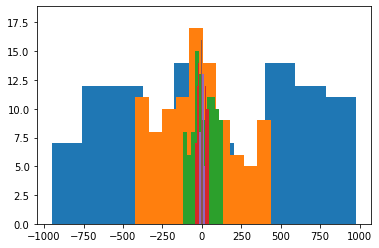

In [ ]:
f1 = lambda x: x**2
f2 = lambda x: (x-2)**2

pop_size = 100
init = np.random.uniform(-1000, 1000, pop_size).reshape(-1, 1)
init_vals = np.hstack((f1(init), f2(init)))

nsga_ii = NSGA_II(1, pop_size, 2, init, init_vals)

plt.figure()

for t in range(10):
    plt.hist(nsga_ii.get_population())
    children = nsga_ii.generate_children(avg_crossover, random_mutation)
    children_vals = np.hstack((f1(children), f2(children)))
    nsga_ii.replace_population(children, children_vals)

plt.hist(nsga_ii.get_population())

(array([ 8., 13.,  8., 11.,  9., 10.,  9., 11., 11., 10.]),
 array([2.76817797e-04, 2.00552066e-01, 4.00827315e-01, 6.01102563e-01,
        8.01377812e-01, 1.00165306e+00, 1.20192831e+00, 1.40220356e+00,
        1.60247881e+00, 1.80275405e+00, 2.00302930e+00]),
 <a list of 10 Patch objects>)

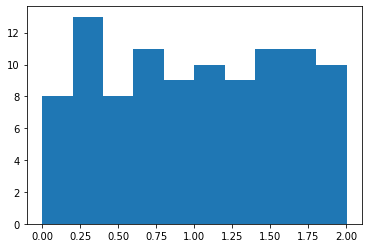

In [ ]:
plt.hist(nsga_ii.get_population())

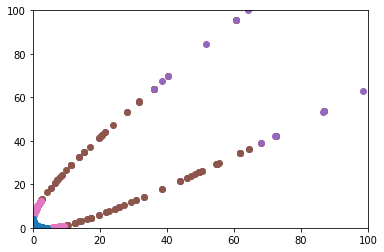

In [ ]:
f1 = lambda x: x**2
f2 = lambda x: (x-2)**2

pop_size = 100
init = np.random.uniform(-1000, 1000, pop_size).reshape(-1, 1)
init_vals = np.hstack((f1(init), f2(init)))

nsga_ii = NSGA_II(1, pop_size, 2, init, init_vals)

plt.figure()
plt.xlim((0, 100))
plt.ylim((0, 100))


for t in range(10):
    vals = nsga_ii.get_values()
    plt.scatter(vals[:, 0], vals[:, 1])
    children = nsga_ii.generate_children(avg_crossover, random_mutation)
    children_vals = np.hstack((f1(children), f2(children)))
    nsga_ii.replace_population(children, children_vals)

vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

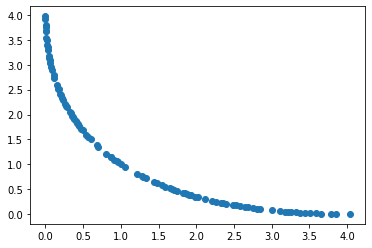

In [ ]:
vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

### FON


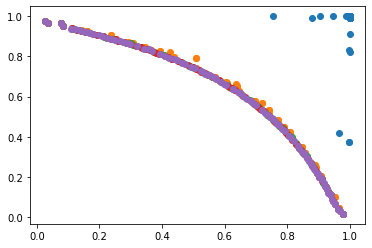

In [ ]:
f1 = lambda x: 1 - np.exp(-np.sum((x - 1/(3**(1/2)))**2))
f2 = lambda x: 1 - np.exp(-np.sum((x + 1/(3**(1/2)))**2))

pop_size = 100
chrom_len = 3
obj_num = 2
n_iters = 20

init = np.random.uniform(-4, 4, (pop_size, chrom_len))
init_vals = np.empty((pop_size, obj_num))
for i in range(pop_size):
    init_vals[i] = f1(init[i]), f2(init[i])

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init, init_vals)

plt.figure()

for t in tqdm(range(n_iters)):
    if(np.mod(t, 5) == 0):
        vals = nsga_ii.get_values()
        plt.scatter(vals[:, 0], vals[:, 1])
    children = nsga_ii.generate_children(avg_crossover, random_mutation)
    children_vals = np.empty((pop_size, obj_num))
    for i in range(pop_size):
        children_vals[i] = f1(children[i]), f2(children[i])
    nsga_ii.replace_population(children, children_vals)

vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

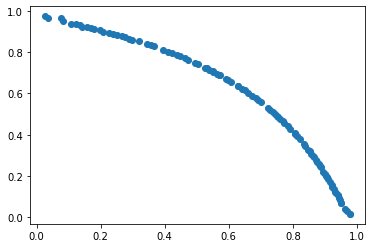

In [ ]:
vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

In [ ]:
nsga_ii.get_population()[:5]

array([[ 0.56916873,  0.59009543,  0.41227514],
       [-0.4633097 , -0.62500574, -0.54596555],
       [ 0.18141336,  0.16616307,  0.1608199 ],
       [ 0.60751234,  0.51251932,  0.30274992],
       [ 0.42432429,  0.46370359,  0.57425955]])

### KUR

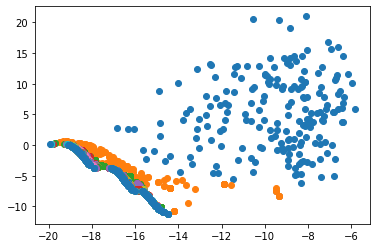

In [ ]:
def f1(x):
    sum = 0
    for i in range(x.shape[0]-1):
        sum+= (-10*np.exp(-0.2*np.sqrt(x[i]**2 +  x[i-1]** 2)))
    return sum

f2 = lambda x: np.sum(np.abs(x)**(0.8) + 5*np.sin(x**3))


pop_size = 200
chrom_len = 3
obj_num = 2
n_iters = 100

init = np.random.uniform(-5, 5, (pop_size, chrom_len))
init_vals = np.empty((pop_size, obj_num))
for i in range(pop_size):
    init_vals[i] = f1(init[i]), f2(init[i])

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init, init_vals)

plt.figure()

for t in tqdm(range(n_iters)):
    if(np.mod(t, 5) == 0):
        vals = nsga_ii.get_values()
        plt.scatter(vals[:, 0], vals[:, 1])
    children = nsga_ii.generate_children(avg_crossover, random_mutation)
    children_vals = np.empty((pop_size, obj_num))
    for i in range(pop_size):
        children_vals[i] = f1(children[i]), f2(children[i])
    nsga_ii.replace_population(children, children_vals)

vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

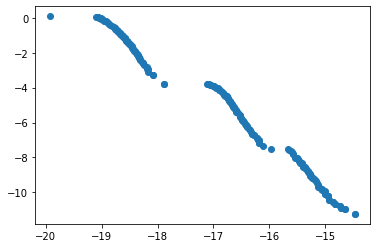

In [ ]:
vals = nsga_ii.get_values()
plt.scatter(vals[:, 0], vals[:, 1])

# MOTSP

## Operatory krzyżowania

In [1]:
def PMX(ind1, ind2):
    ind1 = ind1.copy()
    ind2 = ind2.copy()
    
    n = len(ind1)
    mapping = np.arange(n)
    
    b = np.random.randint(n) + 1
    a = np.random.randint(b)
    
    for i in range(a, b):
        t1, t2 = ind1[i], ind2[i]
        ind1[i], ind2[i] = t2, t1
        mapping[mapping[t1]], mapping[mapping[t2]] = mapping[t2], mapping[t1] 

    for i in range(a):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]    
    for i in range(b, n):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]

    return ind1, ind2


def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]
    
    rest2 = np.array([chrom for chrom in ind1 if chrom not in swath2])
    rest1 = np.array([chrom for chrom in ind2 if chrom not in swath1])
    
    ind1 = np.concatenate((rest2[0:i], swath2, rest2[i:]))
    ind2 = np.concatenate((rest1[0:i], swath1, rest1[i:]))
    
    return ind1, ind2


def CX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]
        
    def color_cycle(idx):
        while cycles[idx] == 0 :
            cycles[idx] = color
            idx = getIdx(ind2[idx], ind1)

    cycles = np.zeros(len(ind1))
    color = 1
    for idx in range(len(ind1)):
        if cycles[idx] == 0 :
            color_cycle(idx)
            color += 1

    mask = (cycles%2).astype(bool)


    child1, child2 = np.zeros(len(ind1)), np.zeros(len(ind1))
    child1[mask], child2[mask] = ind1[mask], ind2[mask]
    neg = np.logical_not
    child1[neg(mask)], child2[neg(mask)] = ind2[neg(mask)], ind1[neg(mask)]
    
    return child1, child2

def PBX(ind1, ind2):
    len = ind1.shape[0]

    chosen_ones = np.random.random(len) < 0.5

    pos1, pos2 = np.empty(len, dtype='int32'), np.empty(len, dtype='int32')
    child1, child2 = np.empty(len, dtype='int32'), np.empty(len, dtype='int32')
    for i in range(len):
        pos1[ind1[i]], pos2[ind2[i]] = i, i

    child1[chosen_ones], child2[chosen_ones] = ind1[chosen_ones], ind2[chosen_ones]
    child1[~chosen_ones], child2[~chosen_ones] = ind2[np.sort(pos2[ind1[~chosen_ones]])], ind1[np.sort(pos1[ind2[~chosen_ones]])]

    return child1, child2

## Operatory mutacji

In [2]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def element_transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i], q[j] = q[j], q[i]
    return q

def insert_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q = np.concatenate((q[0:i], q[j:j+1], q[i:j], q[j+1:]))
    return q

## Funkcja celu

In [3]:
def generate_distance_matrix(problem_size, *problems):
    M = np.empty((len(problems), problem_size, problem_size), dtype='int32')
    for prob in range(len(problems)):
        coords = problems[prob].as_dict()['node_coords']
        coords = np.array(list(coords.values()))
        for i in range(problem_size):
            for j in range(problem_size):
                M[prob, i, j] = np.sqrt(((coords[i] - coords[j])**2).sum())
    return M

def tsp_objective_function(perm, objectives_number, distance_matrix):
    result = np.zeros(objectives_number)
    for i in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += distance_matrix[obj][perm[i-1]][perm[i]]
    return result

def evaluate_population_cpu(population, distance_matrix, objectives_number):
    pop_size = population.shape[0]
    vals = np.empty((pop_size, objectives_number))
    for i in range(pop_size):
        vals[i] = tsp_objective_function(population[i], objectives_number, distance_matrix)
    return vals

def load_problem(file):
    problem = tsp.load(f"{file}.tsp")
    if problem.edge_weight_type == "EUC_2D":
        offset = 1
    elif problem.edge_weight_type == "EXPLICIT":
        offset = 0
    else:
        print(problem.edge_weight_format)
        assert False
    n = problem.dimension
    dists = np.empty((n, n), dtype=np.int)
    for i in range(n):
        for j in range(n):
            dists[i, j] = problem.get_weight(i + offset, j + offset)
    return n, dists

def get_tsp_objective_function(file1, file2, solfile=None):
    n, A = load_problem(file1)
    m, B = load_problem(file2)
    assert n == m
    def tsp_objective_function(P):
        def f1(p):
            s = 0
            for i in range(n):
                s += A[p[i - 1], p[i]]
            return s
        def f2(p):
            s = 0
            for i in range(n):
                s += B[p[i - 1], p[i]]
            return s
        pop_size = len(P)
        objective_values = np.empty((pop_size, 2), dtype=np.int)
        for i in range(pop_size):
            objective_values[i, :] = np.array((f1(P[i]), f2(P[i])))
        return objective_values
    tsp_objective_function.dimensions = n
    tsp_objective_function.num_objectives = 2
    tsp_objective_function.solutions = None
    if not solfile is None:
        with open(f"{solfile}.tsp") as file:
            tsp_objective_function.solutions = np.array(list(map(int, file.read().split()))).reshape(-1, 2)
    return tsp_objective_function

In [5]:
@cuda.jit
def evaluate_population(population, distance, res):

    k, obj, ind = cuda.grid(3)

    pop_size, chrom_len = population.shape
    if (ind >= pop_size) or (k >= chrom_len):
        return

    idx = population[ind][k]
    next_idx = population[ind][(k+1)%chrom_len]
    value = distance[obj][idx][next_idx]
    d = 16
    while d>0:
        value += cuda.shfl_down_sync(0xffffffff, value, d)
        d >>= 1
    if (k % 32) == 0:
        cuda.atomic.add(res, (ind, obj), value)
    return 

## Hypervolume

In [4]:
def hypervolume(vals, opt_vals):

    def volume(vals, reference_point):
        last_x = reference_point[0]
        vol = 0
        for p in vals:
            vol+= (last_x - p[0])*(reference_point[1] - p[1])
            last_x = p[0]
        return vol

    # sorting
    reference_point = np.empty(2)
    opt_vals = opt_vals[(np.argsort(opt_vals[:, 1])[::-1])]
    vals = vals[np.argsort(vals[:, 1])[::-1]]
    reference_point[1] = max(opt_vals[0][1], vals[0][1])
    opt_vals = opt_vals[np.argsort(opt_vals[:, 0], kind='stable')[::-1]]
    vals = vals[np.argsort(vals[:, 0], kind='stable')[::-1]]
    reference_point[0] = max(opt_vals[0][0], vals[0][0])

    return volume(vals, reference_point) / volume(opt_vals, reference_point)


## Generowanie losowej populacji

In [5]:
def generate_population(pop_size, chrom_len):
    pop = np.empty((pop_size, chrom_len), dtype='int32')
    for i in range(pop_size):
        ind = np.random.permutation(chrom_len)
        pop[i] = ind
    return pop

## Przykładowy problem MOTSP

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)

In [ ]:
chrom_len = 100
pop_size = 256
obj_num = 2
n_iters = 50

init_pop = generate_population(pop_size, chrom_len)
init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)
    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

NameError: ignored

## Crossover - optymalizacja

In [2]:
def PMX_old(ind1, ind2, i, j):

    res1, res2 = ind1.copy(), ind2.copy()
    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]

    swath1 = ind1[i:j]
    swath2 = ind2[i:j]

    map = {}
    for chrom in swath1:
        if chrom in swath2:
            continue
        else:
            paired = chrom
            while(paired in swath1):
                paired = swath2[getIdx(paired, swath1)]
            map[paired] = chrom
            map[chrom] = paired
    oldInd1, oldInd2 = ind1, ind2

    for idx in range(len(ind1)):
        chrom = ind1[idx]
        if (chrom in swath2) and (chrom in map):
            res1[idx] = map[chrom]
    res1[i:j] = swath2

    for idx in range(len(ind1)):
        chrom = ind2[idx]
        if (chrom in swath1) and (chrom in map):
            res2[idx] = map[chrom]
    res2[i:j] = swath1

    return res1, res2, map

In [3]:
def PMX_new(ind1, ind2, i, j):

    res1, res2 = ind1.copy(), ind2.copy()
    chrom_len = ind1.shape[0]

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]

    swath1 = ind1[i:j]
    swath2 = ind2[i:j]

    is_in_swath1 = np.zeros(chrom_len, dtype='bool')
    is_in_swath2 = np.zeros(chrom_len, dtype='bool')

    is_in_swath1[swath1] = True
    is_in_swath2[swath2] = True

    pos_in_ind1 = np.empty(chrom_len, dtype='int32')
    for pos in range(chrom_len):
        pos_in_ind1[ind1[pos]] = pos

    map = np.zeros(chrom_len, dtype='int32') - 1
    for chrom in swath1:
        if is_in_swath2[chrom]:
            continue
        else:
            paired = chrom
            while(is_in_swath1[paired]):
                paired = ind2[pos_in_ind1[paired]]
            map[paired] = chrom
            map[chrom] = paired


    for idx in range(chrom_len):
        chrom = ind1[idx]
        if (is_in_swath2[chrom]) and (map[chrom] != -1):
            res1[idx] = map[chrom]
    res1[i:j] = swath2

    for idx in range(chrom_len):
        chrom = ind2[idx]
        if (is_in_swath1[chrom]) and (map[chrom] != -1):
            res2[idx] = map[chrom]
    res2[i:j] = swath1

    return res1, res2, map

In [4]:
def PMX_new_new(ind1, ind2, a, b):
    ind1 = ind1.copy()
    ind2 = ind2.copy()
    
    n = len(ind1)
    mapping = np.arange(n)
    
    for i in range(a, b):
        t1, t2 = ind1[i], ind2[i]
        ind1[i], ind2[i] = t2, t1
        mapping[mapping[t1]], mapping[mapping[t2]] = mapping[t2], mapping[t1] 

    for i in range(a):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]    
    for i in range(b, n):
        ind1[i] = mapping[ind1[i]]
        ind2[i] = mapping[ind2[i]]

    return ind1, ind2

In [5]:
def is_perm(p):
    return np.all(np.sort(p) == np.arange(p.shape[0]))

is_perm(np.array([3,2,0,1]))

True

In [6]:
chrom_len = 100
for t in range(10000):
    a = np.random.choice(chrom_len, 2, False)
    i, j = a.min(), a.max()+1
    p, q = np.random.permutation(chrom_len), np.random.permutation(chrom_len)
    res_1, res_2 = PMX_old(p.copy(), q.copy(), i, j), PMX_new(p.copy(), q.copy(), i, j)
    assert (is_perm(res_2[0]) and is_perm(res_2[1]) 
            and np.all(res_1[0] == res_2[0]) and np.all(res_1[1] == res_2[1]))

In [7]:
chrom_len = 100
for t in range(10000):
    a = np.random.choice(chrom_len, 2, False)
    i, j = a.min(), a.max()+1
    p, q = np.random.permutation(chrom_len), np.random.permutation(chrom_len)
    res_1, res_2 = PMX_old(p.copy(), q.copy(), i, j), PMX_new_new(p.copy(), q.copy(), i, j)
    assert (is_perm(res_2[0]) and is_perm(res_2[1]) 
            and np.all(res_1[0] == res_2[0]) and np.all(res_1[1] == res_2[1]))

In [8]:
chrom_len = 100
a = np.random.choice(chrom_len, 2, False)
i, j = a.min(), a.max()
p, q = np.random.permutation(chrom_len), np.random.permutation(chrom_len)

%timeit PMX_new_new(p,q,i,j)
%timeit PMX_new(p,q,i,j)
%timeit PMX_old(p,q,i,j)

68.8 µs ± 929 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
119 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
785 µs ± 42.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
pop_size, chrom_len = 4048, 100
crossover_operator = PMX

pop = generate_population(pop_size, chrom_len)

parent_indices = np.empty(pop_size, dtype=np.int64)
for i in range(pop_size):
    candidates = np.random.choice(pop_size, 1, False)
    parent_indices[i] = candidates[0]

# creating children population
# children_population = np.empty((pop_size, chrom_len), dtype='int32')
# for i in range(pop_size//2):
#     children_population[2*i], children_population[2*i+1] = crossover_operator(pop[parent_indices[2*i]].copy(), pop[parent_indices[2*i+1]].copy())
def f(i):
    return crossover_operator(pop[parent_indices[2*i]].copy(), pop[parent_indices[2*i+1]].copy())


NameError: ignored

In [ ]:
%timeit res = [f(i) for i in range(pop_size//2)]

In [ ]:
p = mp.Pool(4)
%timeit res = p.map(f, range(pop_size//2))

1 loop, best of 3: 2.55 s per loop


# Testy

In [ ]:
def run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance, mutation_probability = 0.25):

    griddim = (1, 1, pop_size)
    blockdim = (128, 2, 1)

    vals_log = []

    init_pop = generate_population(pop_size, chrom_len)
        
    init_vals = np.zeros((pop_size, obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)
    cuda.synchronize()

    nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)


    for t in tqdm(range(n_iters)):

        if(np.mod(t, 50) == 0):
            vals_log.append(nsga_ii.get_values())


        children = nsga_ii.generate_children(PMX, reverse_sequence_mutation,
                                             mutation_probability=mutation_probability).astype('int32')

        children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
        evaluate_population[griddim, blockdim](children, d_distance, children_vals)
        cuda.synchronize()

        nsga_ii.replace_population(children, children_vals)

    return nsga_ii, vals_log

## Prawdopodobieństwo mutacji

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

opt_vals = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

In [ ]:
probs = [0.1, 0.25, 0.4, 0.6, 0.75]
results = []
for prob in probs:
    for t in range(10):
        print(prob, t)
        nsga_ii, _ = run_nsga_ii(100, 512, 2, 300, d_distance, prob)
        hv = hypervolume(nsga_ii.get_values(), opt_vals)
        results.append({'mutation probability': prob, 'hypervolume': hv})
        output.clear()

In [ ]:
results_df = pd.DataFrame(results)
results_df.groupby(by="mutation probability").agg(["mean", "max"])

hypervolume          
                            mean       max
mutation probability                      
0.10                    0.519772  0.578398
0.25                    0.511957  0.564483
0.40                    0.483018  0.554937
0.60                    0.466400  0.505923
0.75                    0.451500  0.486836

In [ ]:
probs = [0.25, 0.4]
results = []
for prob in probs:
    for t in range(10):
        print(prob, t)
        nsga_ii, _ = run_nsga_ii(100, 512, 2, 1000, d_distance, prob)
        hv = hypervolume(nsga_ii.get_values(), opt_vals)
        results.append({'mutation probability': prob, 'hypervolume': hv})
        output.clear()

In [ ]:
results_df = pd.DataFrame(results)
results_df.groupby(by="mutation probability").agg(["mean", "max"])

hypervolume          
                            mean       max
mutation probability                      
0.25                    0.717947  0.747684
0.40                    0.714039  0.762350

## Premia dla najlepszych z kryterium

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

opt_vals = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

0.7637522288109149

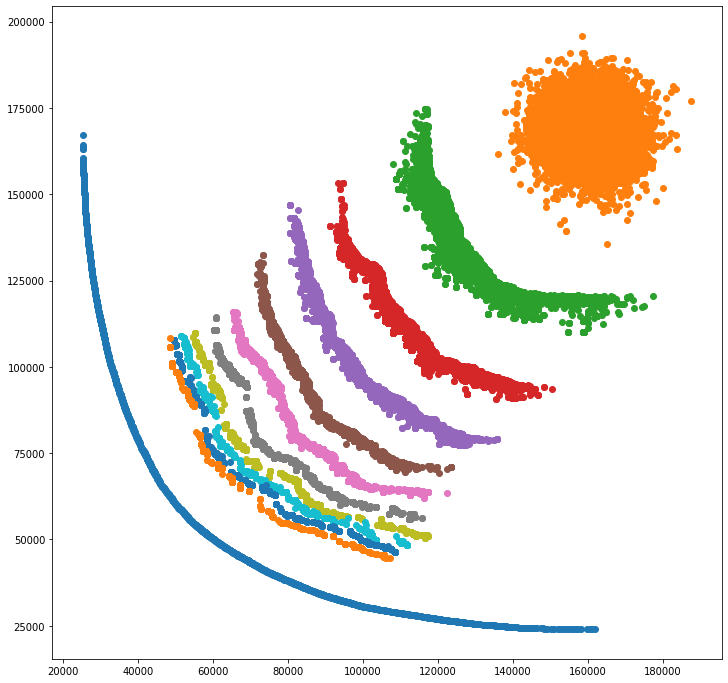

In [ ]:
nsga_ii, vals_log = run_nsga_ii(100, 8192, 2, 500, d_distance)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

In [ ]:
class NSGA_II:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values, best_kept):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.best_kept = best_kept
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size*self.objectives_number + self.best_kept,
                                        self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size*self.objectives_number + self.best_kept,
                                              self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype='int32')
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        # keeping the best in each criterion
        kept_size = self.objectives_number * self.best_kept
        best_population = np.empty(kept_size, self.chromosome_length)
        best_objective_values = np.empty(kept_size, self.objectives_number)
        if kept_size > 0:
            for obj in range(self.objectives_number):
                current_best = np.argsort(combined_objective_values[:, obj])[:self.best_kept]
                best_population[obj*self.best_kept:(obj+1)*self.best_kept] = combined_population[current_best]
                best_objective_values[obj*self.best_kept:(obj+1)*self.best_kept] = combined_objective_values[current_best]
                combined_population = np.delete(combined_population, current_best, axis=0)
                combined_objective_values = np.delete(combined_objective_values, current_best, axis=0)

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        if kept_size > 0:
            self.current_crowding_distances = np.hstack((np.zeros(kept_size), self.current_crowding_distances))
            self.current_population = np.vstack((best_population, self.current_population))
            self.current_objective_values = np.vstack((best_objective_values, self.current_objective_values))
            self.current_pareto_frontier = np.hstack((np.zeros(kept_size), self.current_pareto_frontier))

        return True

In [ ]:
class NSGA_II_GPU:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values, best_kept=0):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.best_kept = best_kept
        self.objectives_number = objectives_number
        self.kept_size = best_kept*objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size + self.kept_size,
                                        self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size + self.kept_size,
                                              self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)

        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='bool')
        next_frontier = np.zeros(pop_size, dtype='bool')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='bool')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            # TODO: for some reason making next_frondier of bool dtype breaks the code,
            #       investigate that
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype='int32')
        for i in range(number_of_offspring):
            # using np.random.choice slows this phase considerably
            candidates = np.random.randint(self.population_size + self.kept_size, size=2)
            while candidates[0] == candidates[1]:
                candidates = np.random.randint(self.population_size + self.kept_size, size=2)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length))
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        # keeping the best in each criterion
        kept_size = self.objectives_number * self.best_kept
        best_population = np.empty((kept_size, self.chromosome_length))
        best_objective_values = np.empty((kept_size, self.objectives_number))
        if kept_size > 0:
            for obj in range(self.objectives_number):
                current_best = np.argsort(combined_objective_values[:, obj])[:self.best_kept]
                best_population[obj*self.best_kept:(obj+1)*self.best_kept] = combined_population[current_best]
                best_objective_values[obj*self.best_kept:(obj+1)*self.best_kept] = combined_objective_values[current_best]
                combined_population = np.delete(combined_population, current_best, axis=0)
                combined_objective_values = np.delete(combined_objective_values, current_best, axis=0)
                
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        if kept_size > 0:
            self.current_crowding_distances = np.hstack((np.zeros(kept_size), self.current_crowding_distances))
            self.current_population = np.vstack((best_population, self.current_population)).astype('int32')
            self.current_objective_values = np.vstack((best_objective_values, self.current_objective_values))
            self.current_pareto_frontier = np.hstack((np.zeros(kept_size)+self.population_size, self.current_pareto_frontier)).astype('int32')

        return True

In [ ]:
np.hstack(((np.zeros(2) + 512), np.array([1,1]))).astype('int32')

array([512, 512,   1,   1], dtype=int32)

In [ ]:
def run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance,
                mutation_probability = 0.25, best_kept=0):

    griddim = (1, 1, pop_size)
    blockdim = (128, 2, 1)

    vals_log = []

    init_pop = generate_population(pop_size + obj_num*best_kept, chrom_len)
        
    init_vals = np.zeros((pop_size + obj_num*best_kept, obj_num), dtype='int32')
    evaluate_population[(1, 1, pop_size + obj_num*best_kept), blockdim](init_pop, d_distance, init_vals)
    cuda.synchronize()

    nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals, best_kept)


    for t in tqdm(range(n_iters)):

        if(np.mod(t, 50) == 0):
            vals_log.append(nsga_ii.get_values())


        children = nsga_ii.generate_children(PMX, reverse_sequence_mutation,
                                             mutation_probability=mutation_probability).astype('int32')

        children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
        evaluate_population[griddim, blockdim](children, d_distance, children_vals)
        cuda.synchronize()

        nsga_ii.replace_population(children, children_vals)

    return nsga_ii, vals_log

0.545977061975214

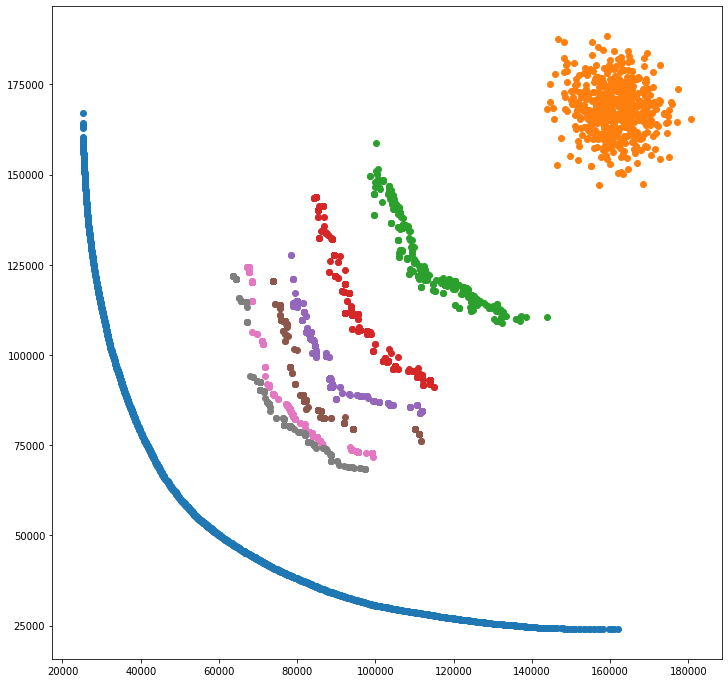

In [ ]:
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 300, d_distance, best_kept=0)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.6143958534182689

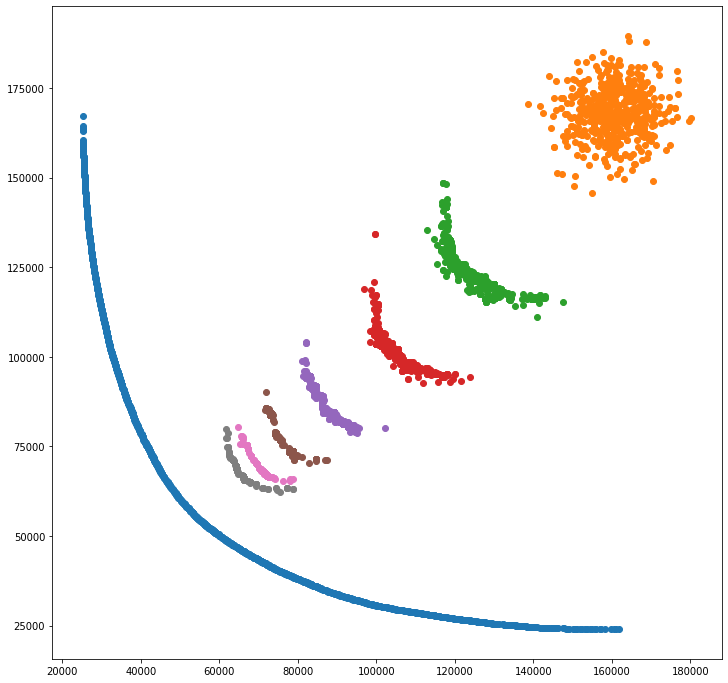

In [ ]:
# Zawsze wygrywają turnieje
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 300, d_distance, best_kept=4)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.4886109692868096

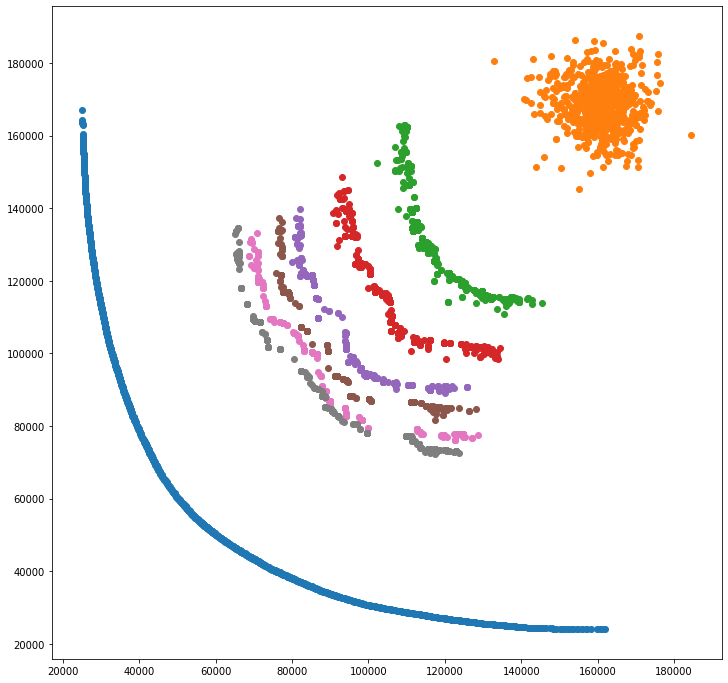

In [ ]:
# Zawsze przegrywają turnieje
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 300, d_distance, best_kept=32)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.6446319014691795

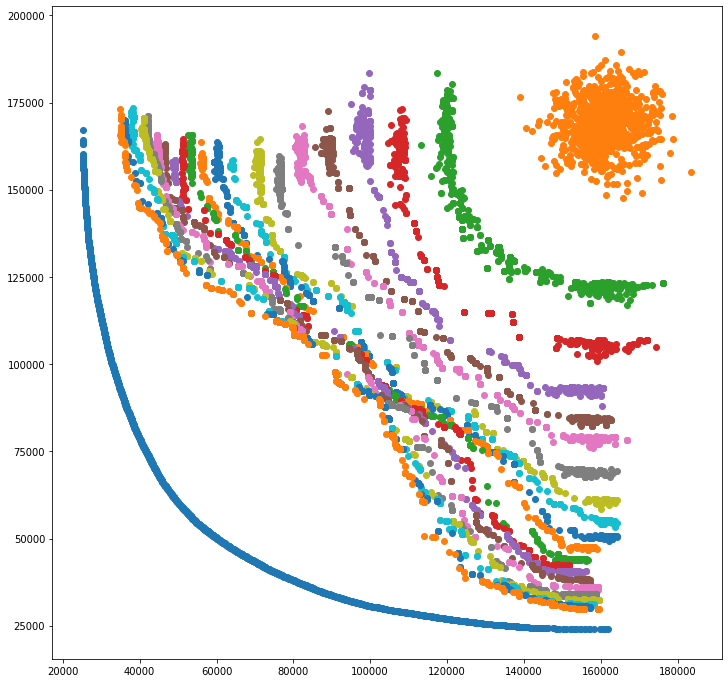

In [ ]:
# Zawsze przegrywają turnieje
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 1000, d_distance, best_kept=128)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.7947175290268601

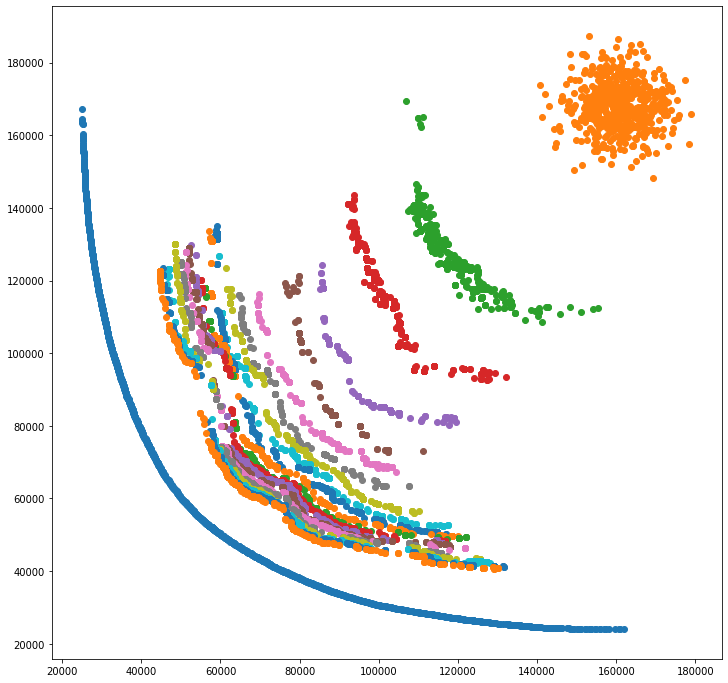

In [ ]:
# Zawsze przegrywają turnieje
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 1000, d_distance, best_kept=16)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.6689667656434043

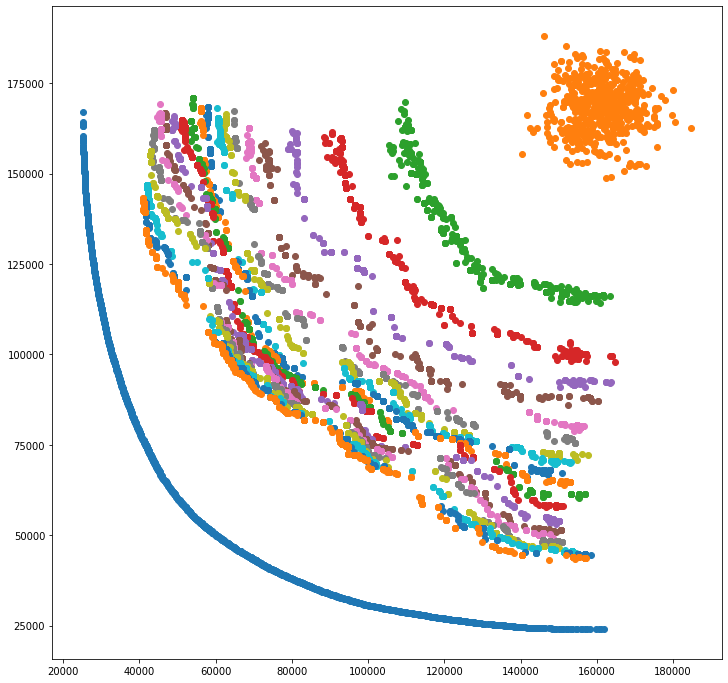

In [ ]:
# Zawsze przegrywają turnieje
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 1000, d_distance, best_kept=32)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8285817531342482

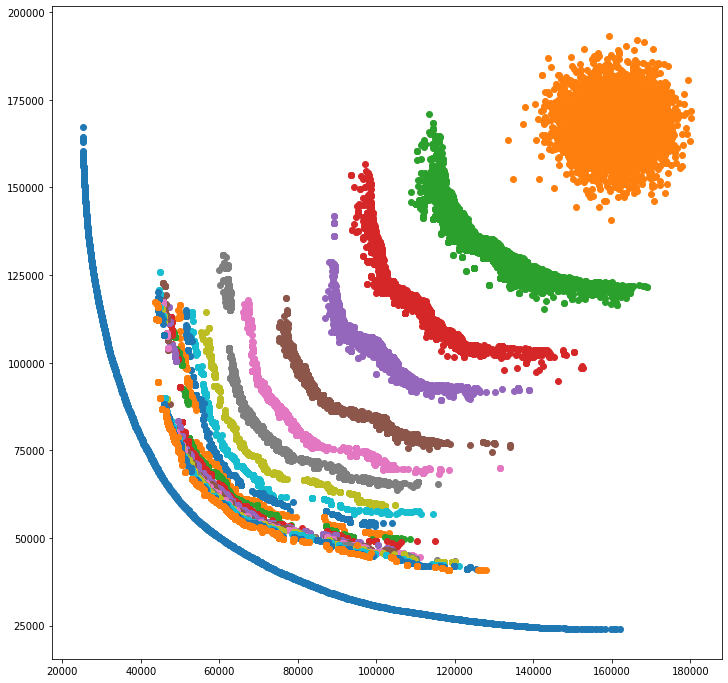

In [ ]:
nsga_ii, vals_log = run_nsga_ii(100, 4096, 2, 1000, d_distance, best_kept=32)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8711626699802796

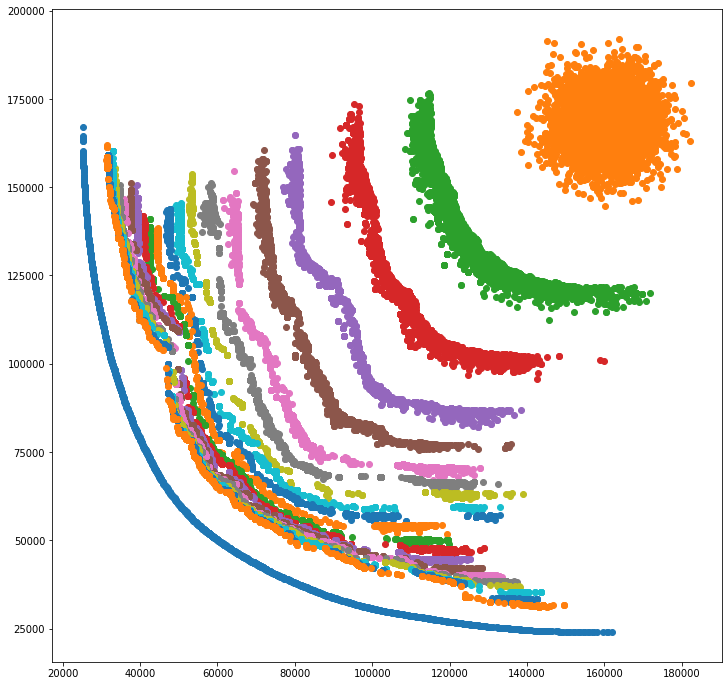

In [93]:
nsga_ii, vals_log = run_nsga_ii(100, 4096, 2, 1000, d_distance, best_kept=256)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8789292303101638

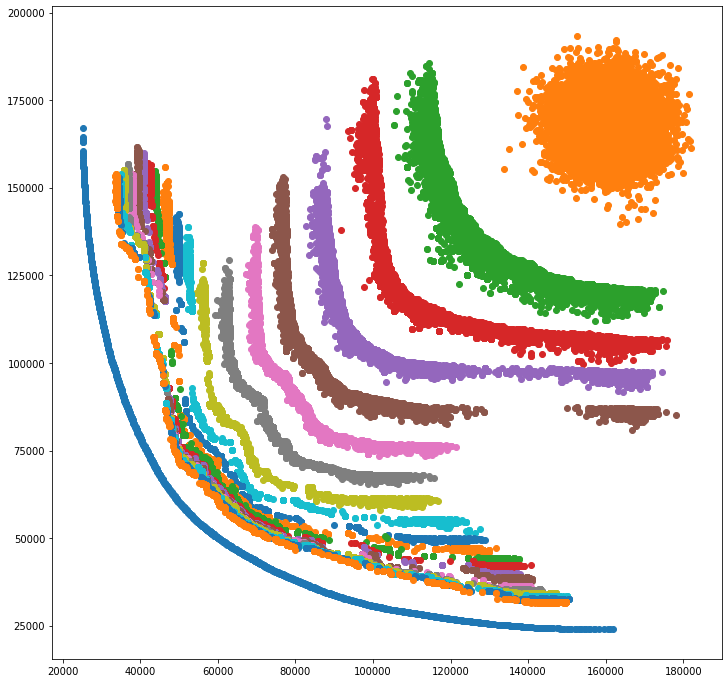

In [95]:
nsga_ii, vals_log = run_nsga_ii(100, 8192, 2, 1000, d_distance, best_kept=512)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8941728280015278

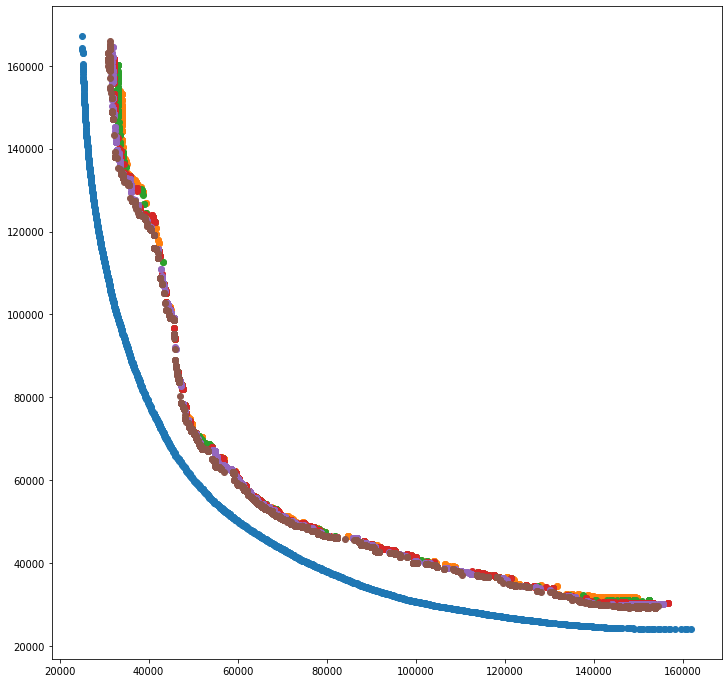

In [98]:
n_iters = 200
pop_size = 8192
griddim = (1, 1, pop_size//2)
blockdim = (128, 2, 2)

plt.figure(figsize=(12,12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], 2), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8827618877343724

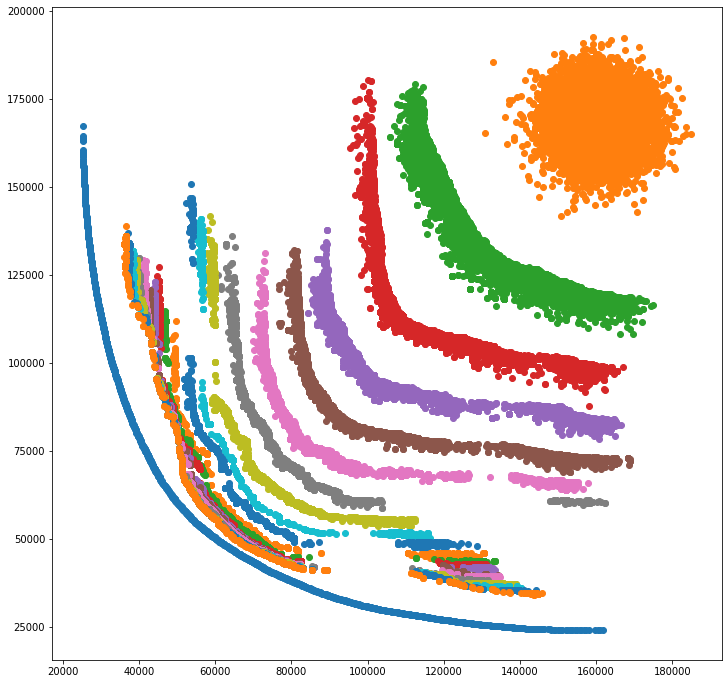

In [100]:
nsga_ii, vals_log = run_nsga_ii(100, 8192, 2, 1000, d_distance, best_kept=256)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.8914832440868377

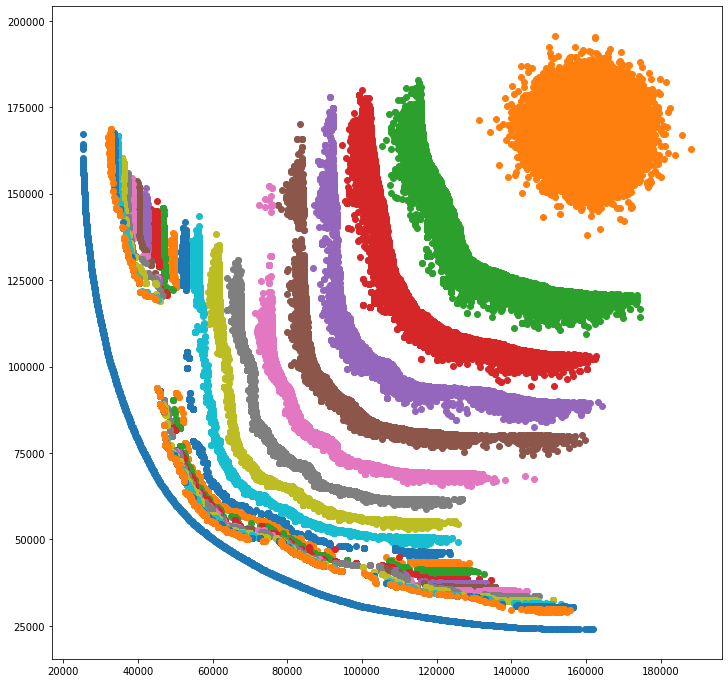

In [101]:
nsga_ii, vals_log = run_nsga_ii(100, 16384, 2, 1000, d_distance, best_kept=1024)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

0.9129418942912098

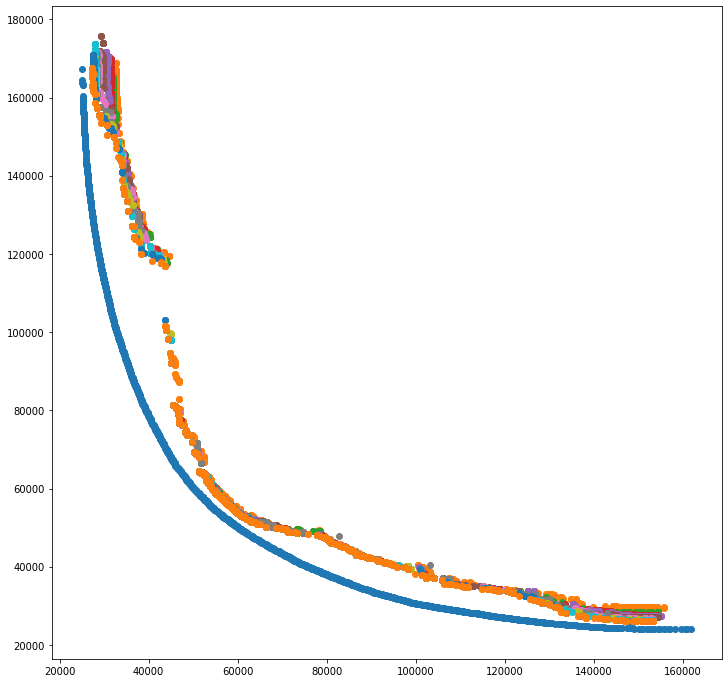

In [102]:
n_iters = 500
pop_size = 16384
griddim = (1, 1, pop_size//2)
blockdim = (128, 2, 2)

plt.figure(figsize=(12,12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], 2), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

hypervolume(current_vals, opt_vals)

In [105]:
pop_bk = nsga_ii.get_population()
vals_bk = nsga_ii.get_values()

In [108]:
chosen_ones = np.random.choice(16384+2048, 16384, replace=False) 

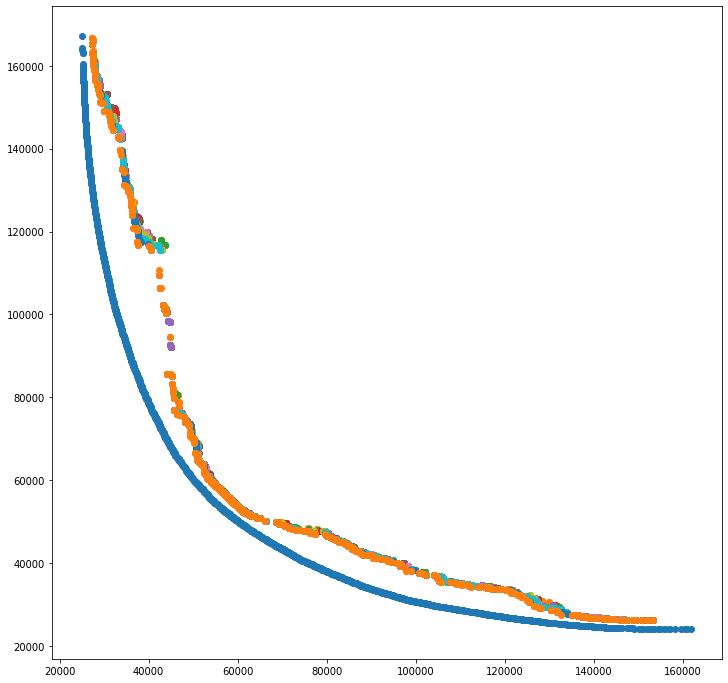

In [112]:
chrom_len = 100
pop_size = 16384
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = pop_bk[chosen_ones]
init_vals = vals_bk[chosen_ones]

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

# Rozwiązania

In [ ]:
def run_nsga_ii(chrom_len, pop_size, obj_num, n_iters, d_distance):

    griddim = (1, 1, pop_size)
    blockdim = (128, 2, 1)

    vals_log = []

    init_pop = generate_population(pop_size, chrom_len)
        
    init_vals = np.zeros((pop_size, obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

    nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)


    for t in tqdm(range(n_iters)):

        if(np.mod(t, 50) == 0):
            vals_log.append(nsga_ii.get_values())


        children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

        children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
        evaluate_population[griddim, blockdim](children, d_distance, children_vals)

        nsga_ii.replace_population(children, children_vals)

    return nsga_ii, vals_log

## euclidAB100

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

opt_vals = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

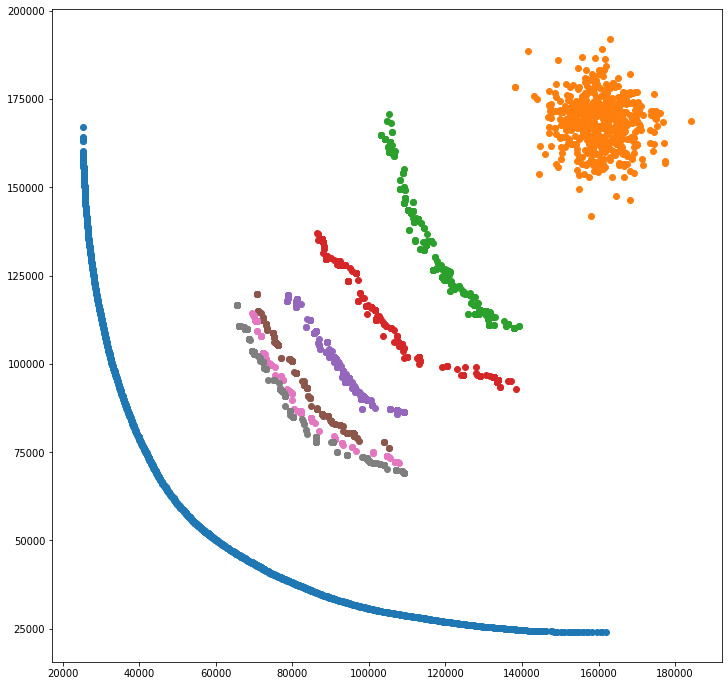

In [ ]:
nsga_ii, vals_log = run_nsga_ii(100, 512, 2, 300, d_distance)

plt.figure(figsize=(12, 12))
plt.scatter(opt_vals[:, 0], opt_vals[:, 1])

for vals in vals_log:
    plt.scatter(vals[:, 0], vals[:, 1])

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])


0.7218276540771474


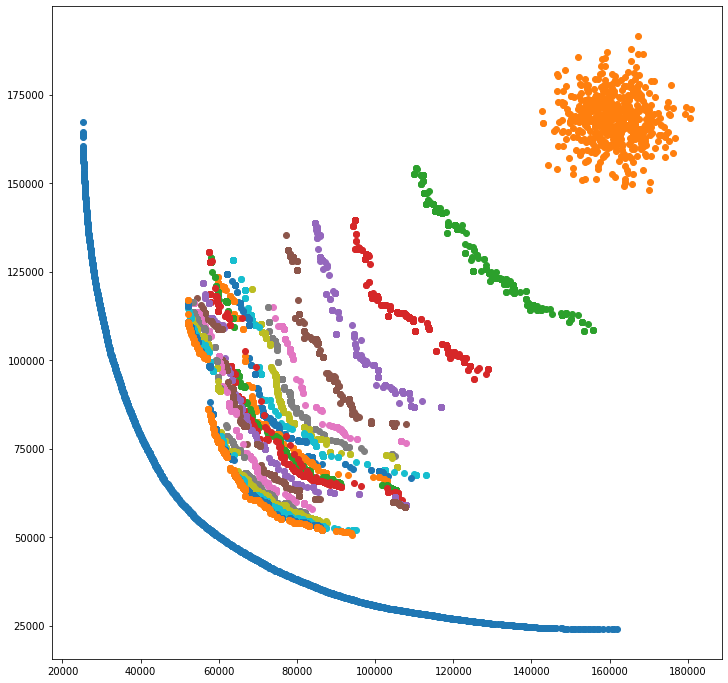

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 1000

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

hypervolume_log = []

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])
        hypervolume_log.append(hypervolume(current_vals, solutionsAB))


    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])
hypervolume_log.append(hypervolume(current_vals, solutionsAB))

print(hypervolume_log[-1])

## kroAB100

In [ ]:
kroA100 = tsplib95.load('/content/gdrive/My Drive/TSPLIB/kroA100.tsp')
kroB100 = tsplib95.load('/content/gdrive/My Drive/TSPLIB/kroB100.tsp')

In [ ]:
distance_matrix = generate_distance_matrix(100, kroA100, kroB100)

In [ ]:
d_distance = cuda.to_device(distance_matrix)

In [ ]:
solutionsAB = np.loadtxt('points.3.1', dtype='int32', usecols=np.arange(6, 106))
solutionsAB.shape

(2699, 100)

In [ ]:
sol_vals = np.zeros((100, 2))

griddim = (1, 1, 2699)
blockdim = (128, 2, 1)

evaluate_population[griddim, blockdim](solutionsAB, d_distance, sol_vals)

In [ ]:
sol_vals[:5]

array([[47457., 53280.],
       [49474., 51289.],
       [48996., 51772.],
       [65941., 38733.],
       [59132., 43080.]])

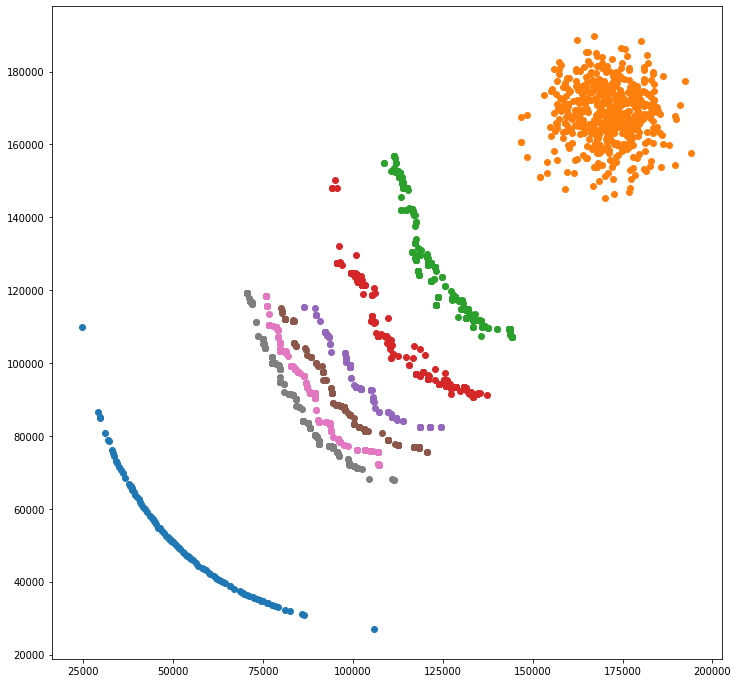

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 300

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')


evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(sol_vals[:, 0], sol_vals[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children = children.astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

# CUDA

## Algorytm w praktyce - CPU

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

In [ ]:
def PMX_old(ind1, ind2):

    res1, res2 = ind1.copy(), ind2.copy()
    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]

    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]

    map = {}
    for chrom in swath1:
        if chrom in swath2:
            continue
        else:
            paired = chrom
            while(paired in swath1):
                paired = swath2[getIdx(paired, swath1)]
            map[paired] = chrom
            map[chrom] = paired
    oldInd1, oldInd2 = ind1, ind2

    for idx in range(len(ind1)):
        chrom = ind1[idx]
        if (chrom in swath2) and (chrom in map):
            res1[idx] = map[chrom]
    res1[i:j] = swath2

    for idx in range(len(ind1)):
        chrom = ind2[idx]
        if (chrom in swath1) and (chrom in map):
            res2[idx] = map[chrom]
    res2[i:j] = swath1

    return res1, res2

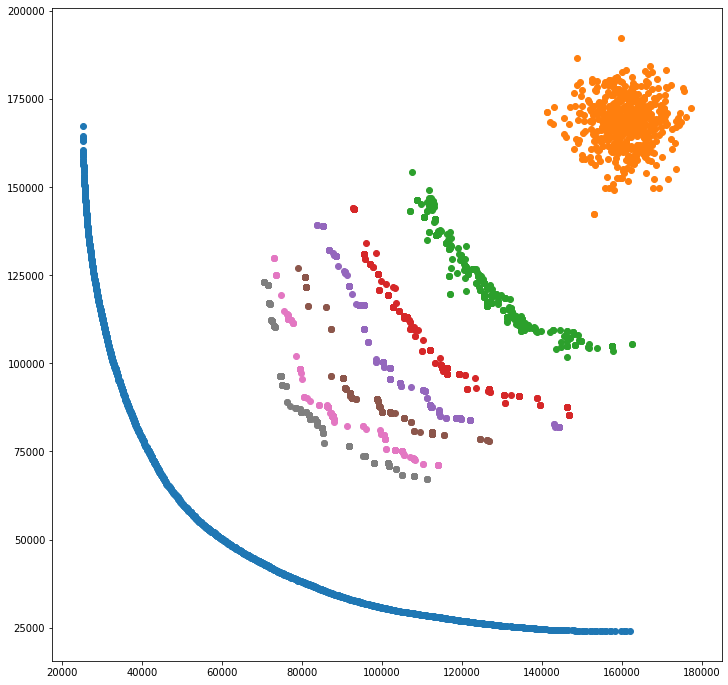

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 300

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX_old, reverse_sequence_mutation).astype('int32')
    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)
    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

## CPU - czas działania

In [ ]:
class NSGA_II_prints:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]


        time1 = time.time()

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        print("     Selection:                      ", time.time() - time1)

        time1 = time.time()
        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]
        print("     Recombination:                  ", time.time() - time1)

        time1 = time.time()
        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])
        print("     Mutation:                       ", time.time() - time1)

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        time2 = time.time()
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        print("         Non dominated sort:         ", time.time() - time2)


        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        time2 = time.time()
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]
        print("         Distance assignment:        ", time.time() - time2)

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 3

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX_old, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          2.766256093978882
         Distance assignment:         0.0017406940460205078

Iteration number:                     0

     Selection:                       0.01419210433959961
     Recombination:                   0.27422285079956055
     Mutation:                        0.003378152847290039
     Population evaluation:           0.12600994110107422
     Population replacement:
         Non dominated sort:          10.295392513275146
         Distance assignment:         0.0015685558319091797
     Population replacement - sum:    10.299115419387817

Iteration - sum:                      10.717824459075928

Iteration number:                     1

     Selection:                       0.019649982452392578
     Recombination:                   0.26890063285827637
     Mutation:                        0.006953239440917969
     Population evaluation:           0.12929415702819824
     Population replacement:
         Non dominated sor

## Ewaluacja funkcji celu

In [ ]:
def generate_population(pop_size, chrom_len):
    pop = np.empty((pop_size, chrom_len), dtype='int32')
    for i in range(pop_size):
        ind = np.random.permutation(chrom_len)
        pop[i] = ind
    return pop

def generate_distance_matrix(problem_size, *problems):
    M = np.empty((len(problems), problem_size, problem_size), dtype='int32')
    for prob in range(len(problems)):
        coords = problems[prob].as_dict()['node_coords']
        coords = np.array(list(coords.values()))
        for i in range(problem_size):
            for j in range(problem_size):
                M[prob, i, j] = np.sqrt(((coords[i] - coords[j])**2).sum())
    return M

def tsp_objective_function(perm, objectives_number, distance_matrix):
    result = np.zeros(objectives_number)
    for i in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += distance_matrix[obj][perm[i-1]][perm[i]]
    return result

def evaluate_population_cpu(population, distance_matrix, objectives_number):
    pop_size = population.shape[0]
    vals = np.empty((pop_size, objectives_number))
    for i in range(pop_size):
        vals[i] = tsp_objective_function(population[i], objectives_number, distance_matrix)
    return vals

In [ ]:
@cuda.jit
def evaluate_population(population, distance, res):

    k, obj, ind = cuda.grid(3)

    pop_size, chrom_len = population.shape
    if (ind >= pop_size) or (k >= chrom_len):
        return

    idx = population[ind][k]
    next_idx = population[ind][(k+1)%chrom_len]
    value = distance[obj][idx][next_idx]
    d = 16
    while d>0:
        value += cuda.shfl_down_sync(0xffffffff, value, d)
        d >>= 1
    if (k % 32) == 0:
        cuda.atomic.add(res, (ind, obj), value)
    return 

In [ ]:
problemA = tsplib95.load("euclidA100.tsp")
problemB = tsplib95.load("euclidB100.tsp")

In [ ]:
chrom_len = 100
pop_size = 2048
obj_num = 2

init_pop = generate_population(pop_size, chrom_len)

In [ ]:
distance = generate_distance_matrix(100, problemA, problemB)

In [ ]:
d_distance = cuda.to_device(distance)

In [ ]:
res = np.zeros((pop_size, obj_num), dtype='int32')
blocks_per_grid = (1, 1, pop_size)
blockdim = (128, 2, 1)

%timeit evaluate_population[blocks_per_grid, blockdim](init_pop, d_distance, res)
%timeit evaluate_population_cpu(init_pop, distance, 2)

The slowest run took 120.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.62 ms per loop
1 loop, best of 3: 522 ms per loop


In [ ]:
n_iters = 10

for t in range(n_iters):
    population = generate_population(pop_size, chrom_len)

    vals_gpu = np.zeros((pop_size, obj_num), dtype='int32')

    blocks_per_grid = (1, 1, pop_size)
    blockdim = (128, 2, 1)
    evaluate_population[blocks_per_grid, blockdim](population, d_distance, vals_gpu)

    vals_cpu = evaluate_population_cpu(population, distance, obj_num)

    assert np.all(vals_gpu == vals_cpu)

## Sortowanie

In [ ]:
def non_dominated_sort_cpu(objective_values):

    def dominates(vals1, vals2):
        return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

    size = objective_values.shape[0]
    pareto_frontier = np.empty(size, dtype=int)
    current_frontier_number = 1
    current_frontier_members = []
    # number of solutions dominating p
    dominating_count = np.zeros(size, dtype=int)
    # set of solutions dominated by p
    dominated = [None] * size 

    for p in range(size):
        dominated[p] = []
        for q in range(size):
            if dominates(objective_values[p], objective_values[q]):
                dominated[p].append(q)
            elif dominates(objective_values[q], objective_values[p]):
                dominating_count[p] += 1
        if dominating_count[p] == 0:
            pareto_frontier[p] = current_frontier_number
            current_frontier_members.append(p)

    while current_frontier_members != []:
        current_frontier_number += 1
        new_frontier_members = []
        for p in current_frontier_members:
            for q in dominated[p]:
                dominating_count[q] -= 1
                if dominating_count[q] == 0:
                    pareto_frontier[q] = current_frontier_number
                    new_frontier_members.append(q)
        current_frontier_members = new_frontier_members
    
    return pareto_frontier

In [ ]:
@cuda.jit
def check_domination(pop_vals, dominated, dom_count):
    q, p = cuda.grid(2)

    pop_size = pop_vals.shape[0]
    if (p >= pop_size) or (q >= pop_size):
        return

    if (pop_vals[p][0] <= pop_vals[q][0] and pop_vals[p][1] <= pop_vals[q][1] and
        (pop_vals[p][0] < pop_vals[q][0] or pop_vals[p][1] < pop_vals[q][1])):
        # maska bitowa = atomic add
        dominated[p, q] = 1


    elif (pop_vals[q][0] <= pop_vals[p][0] and pop_vals[q][1] <= pop_vals[p][1] and
            (pop_vals[q][0] < pop_vals[p][0] or pop_vals[q][1] < pop_vals[p][1])):
        cuda.atomic.add(dom_count, p, 1)


@cuda.jit
def find_first_frontier(dom_count, frontier, rank):
    p = cuda.grid(1)
    if dom_count[p] == 0:
        frontier[p] = 1
        rank[p] = 1


@cuda.jit
def remove_current_frontier(dominated, dom_count, current_rank,
                            current_frontier, next_frontier, rank):
    q, p = cuda.grid(2)

    pop_size = dominated.shape[0]
    if (p >= pop_size) or (q >= pop_size) or current_frontier[p] == 0:
        return
    
    if dominated[p, q] == 1:
        if cuda.atomic.add(dom_count, q, -1) == 1:
            rank[q] = current_rank
            next_frontier[q] = 1

In [ ]:
def non_dominated_sort(pop_vals):

    def is_not_empty(frontier):
        return np.any(frontier == 1)


    pop_size = pop_vals.shape[0]

    current_frontier = np.zeros(pop_size, dtype='bool')
    next_frontier = np.zeros(pop_size, dtype='bool')
    current_rank = 1

    dom = np.zeros((pop_size, pop_size), dtype='bool')
    dom_count = np.zeros(pop_size, dtype='int32')
    rank = np.zeros(pop_size, dtype='int32')

    d_dom = cuda.to_device(dom)
    d_dom_count = cuda.to_device(dom_count)
    d_rank = cuda.to_device(rank)

    griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
    blockdim = (32, 32)

    check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
    find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

    while(is_not_empty(current_frontier)):
        next_frontier = np.zeros(pop_size)
        current_rank += 1
        remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                       current_frontier, next_frontier, d_rank)
        current_frontier = next_frontier

    rank = d_rank.copy_to_host()
    return rank

In [ ]:
chrom_len = 100
pop_size = 1024
obj_num = 2

population = generate_population(pop_size, chrom_len)

vals = np.zeros((pop_size, obj_num), dtype='int32')

blocks_per_grid = (1, 1, pop_size)
blockdim = (128, 2, 1)
evaluate_population[blocks_per_grid, blockdim](population, d_distance, vals)

In [ ]:
%timeit non_dominated_sort(vals)
%timeit non_dominated_sort_cpu(vals)

10 loops, best of 3: 68.4 ms per loop
1 loop, best of 3: 10.2 s per loop


In [ ]:
assert np.all(non_dominated_sort(vals) == non_dominated_sort_cpu(vals))

## GPU - czas działania

In [ ]:
class NSGA_II_GPU_prints:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)


        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='bool')
        next_frontier = np.zeros(pop_size, dtype='bool')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='bool')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        time1 = time.time()
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.randint(self.population_size, size=2)
            while candidates[0] == candidates[1]:
                candidates = np.random.randint(self.population_size, size=2)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]
        print("     Selection:                      ", time.time() - time1)

        # creating children population
        time1 = time.time()
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]
        print("     Recombination:                  ", time.time() - time1)

        # mutating children population
        time1 = time.time()
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])
        print("     Mutation:                       ", time.time() - time1)

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        time2 = time.time()
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        print("         Non dominated sort:         ", time.time() - time2)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        time2 = time.time()
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]
        print("         Distance assignment:        ", time.time() - time2)

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 3

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          0.056609392166137695
         Distance assignment:         0.0021021366119384766

Iteration number:                     0

     Selection:                       0.01078343391418457
     Recombination:                   0.058889150619506836
     Mutation:                        0.003121614456176758
     Population evaluation:           0.001954793930053711
     Population replacement:
         Non dominated sort:          0.06720399856567383
         Distance assignment:         0.0017094612121582031
     Population replacement - sum:    0.07023930549621582

Iteration - sum:                      0.14593172073364258

Iteration number:                     1

     Selection:                       0.012668609619140625
     Recombination:                   0.0612332820892334
     Mutation:                        0.0035636425018310547
     Population evaluation:           0.0020551681518554688
     Population replacement:
         Non dom

Dla populacji wielkości 512 udało się zredukować czas sortowania z ~ 9.5 sekundy do ~ 0.04 sekundy,  
tym samym zmniejszając czas trwania iteracji z ~ 9.8 sekundy do ~ 0.34 sekundy.  
Po zoptymalizowaniu niektórych częsci kodu oraz użyciu GPU do ewaluacji populacji,  
całkowity czas trwania iteracji zmniejszył się do ~0.14 sekundy.

In [ ]:
chrom_len = 100
pop_size = 16384
obj_num = 2
n_iters = 3

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          1.7888572216033936
         Distance assignment:         0.04424142837524414

Iteration number:                     0

     Selection:                       0.2987968921661377
     Recombination:                   1.829150915145874
     Mutation:                        0.09987115859985352
     Population evaluation:           0.005529165267944336
     Population replacement:
         Non dominated sort:          7.82182502746582
         Distance assignment:         0.04410552978515625
     Population replacement - sum:    7.876167297363281

Iteration - sum:                      10.110450983047485

Iteration number:                     1

     Selection:                       0.2035200595855713
     Recombination:                   1.9165713787078857
     Mutation:                        0.09295916557312012
     Population evaluation:           0.007399797439575195
     Population replacement:
         Non dominated sort:          

In [ ]:
chrom_len = 100
pop_size = 32768
obj_num = 2
n_iters = 3

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          7.762798309326172
         Distance assignment:         0.08474206924438477

Iteration number:                     0

     Selection:                       0.48434925079345703
     Recombination:                   3.723581075668335
     Mutation:                        0.21783709526062012
     Population evaluation:           0.008616447448730469
     Population replacement:
         Non dominated sort:          39.69694137573242
         Distance assignment:         0.11340188980102539
     Population replacement - sum:    39.829622745513916

Iteration - sum:                      44.265469551086426

Iteration number:                     1

     Selection:                       0.4171297550201416
     Recombination:                   3.7114527225494385
     Mutation:                        0.1971890926361084
     Population evaluation:           0.013009071350097656
     Population replacement:
         Non dominated sort:         

## Algorytm w praktyce - GPU

In [ ]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

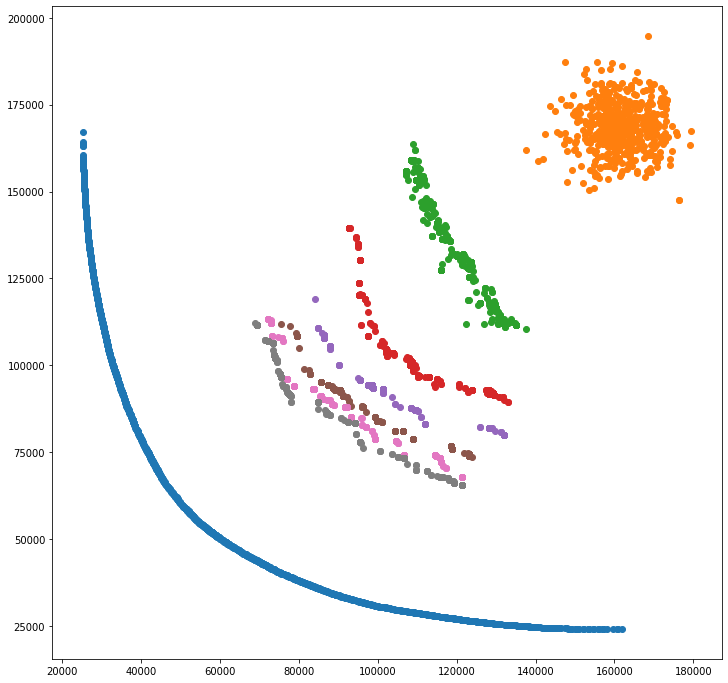

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 300

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

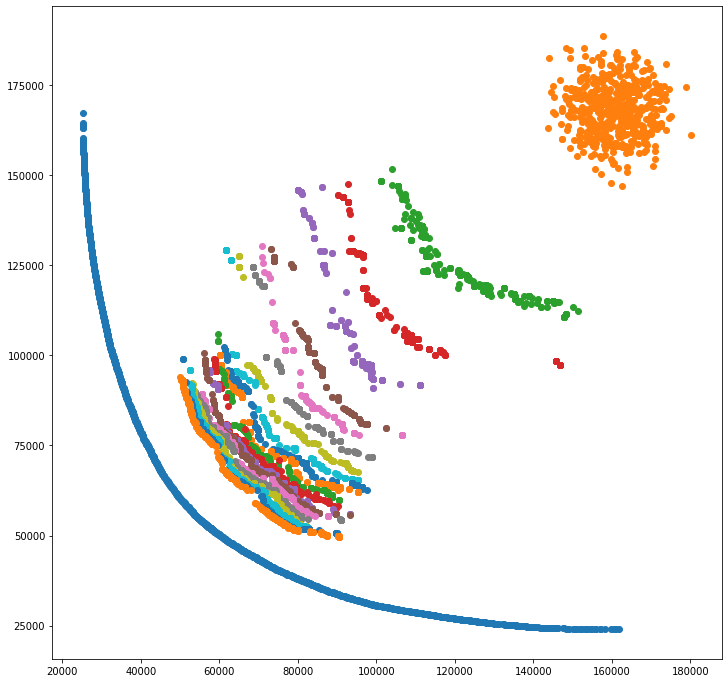

In [ ]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 1000

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

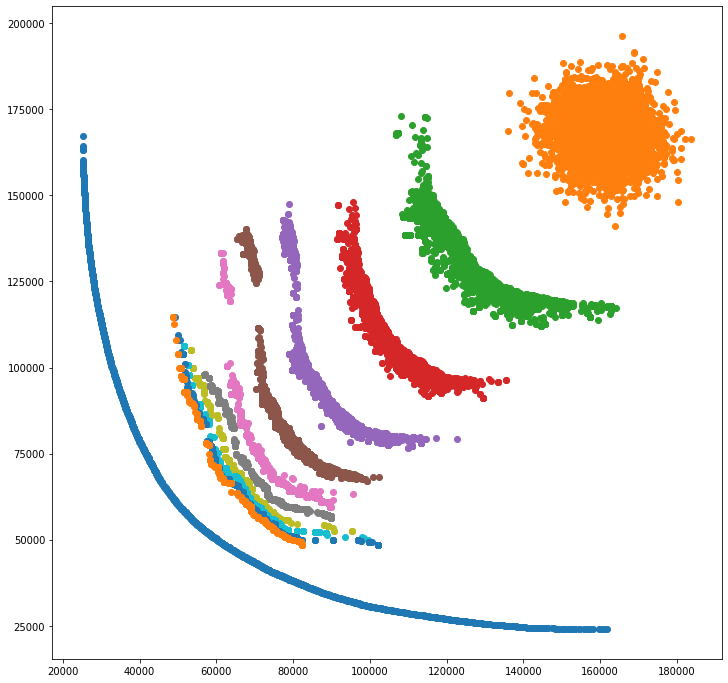

In [ ]:
chrom_len = 100
pop_size = 4096
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')


evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

Optymalizacja kodu CPU:  
2.5 h -> 45 min

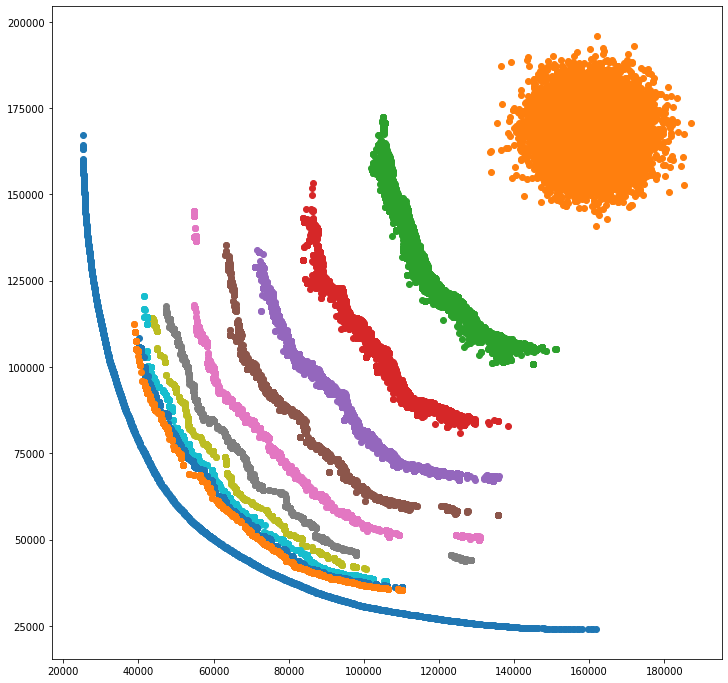

In [ ]:
chrom_len = 100
pop_size = 16384
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

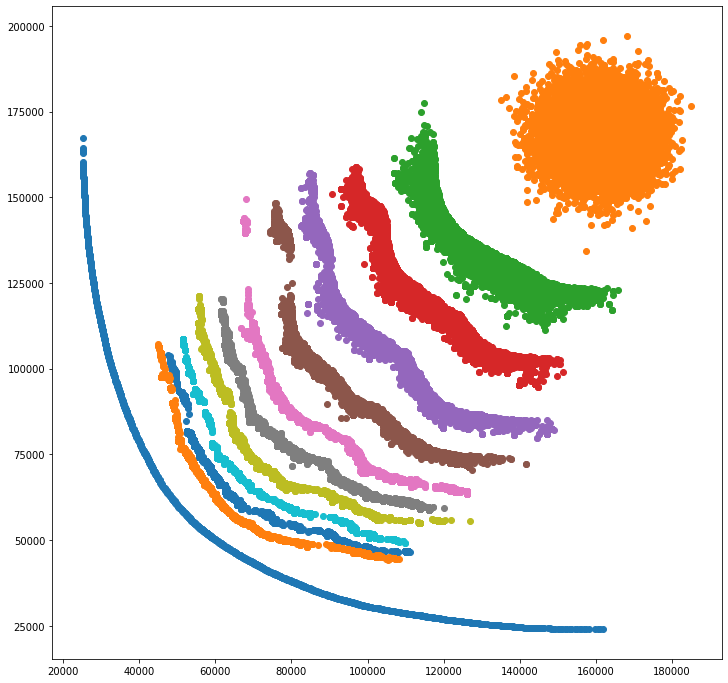

In [ ]:
chrom_len = 100
pop_size = 16384
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

Optymalizacje CPU dla 32k:  
Dwukrotne przyspieszenie
* refecatoring PMX
* selekcja: użycie np.random.randint zamiast np.random.choice (16s/it -> 0.5s/it)


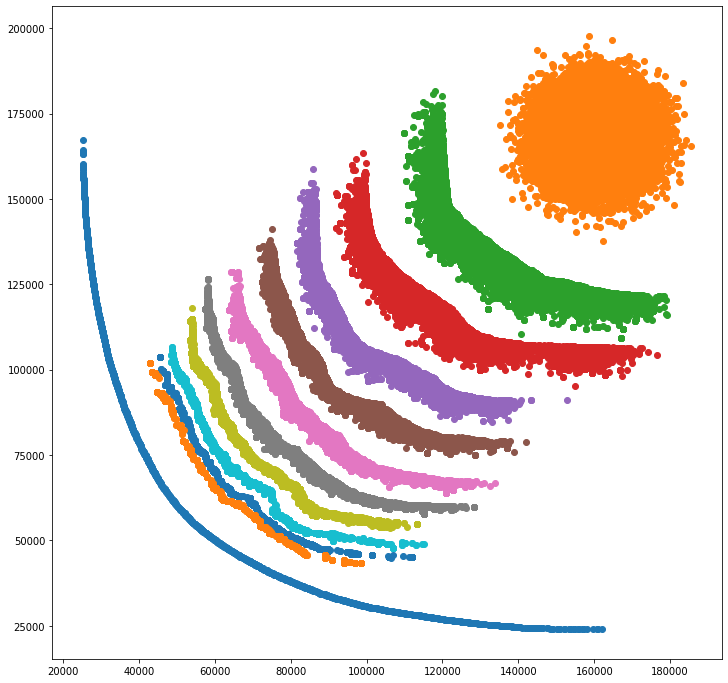

In [ ]:
chrom_len = 100
pop_size = 32768
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size//2)
blockdim = (128, 2, 2)

init_pop = generate_population(pop_size, chrom_len)
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

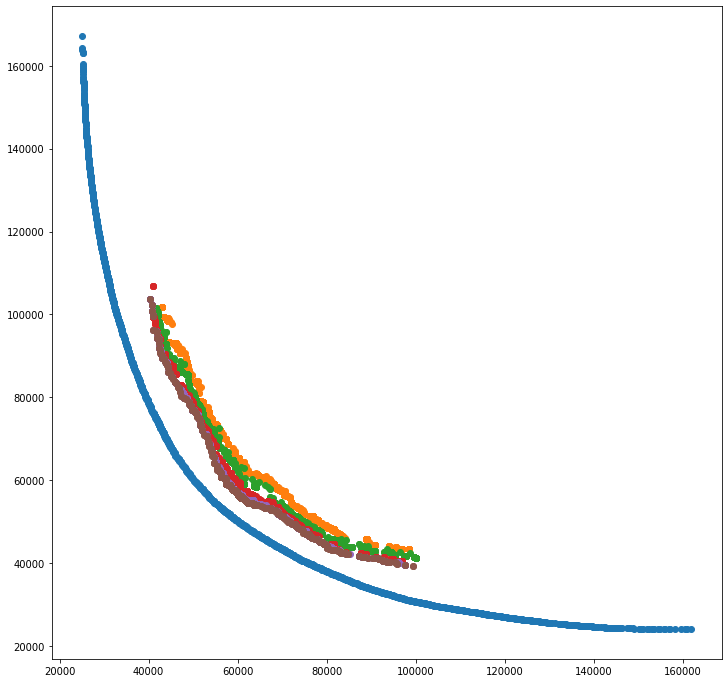

In [ ]:
n_iters = 200

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation).astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

# MOEA/D

## Generowanie wektora wag

In [10]:
def generate_weights(N, num_objectives):
    assert num_objectives == 2
    span = np.linspace(0, 1, N).reshape(-1, 1)
    return np.hstack((span, 1 - span))

## Metody dekompozycji

In [9]:
def weighted_sum(objective_values, weights, *args):
    return np.sum(objective_values * weights, axis=1)

def tchebycheff(objective_values, weights, reference_point, *args):
    return np.max(weights * np.abs(objective_values - reference_point), axis=1)

## Algorytm - oryginalny

In [10]:
class MOEAD:
    def __init__(self, objective_f, iterations, offspring_size, num_nearest, weights,
                 decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob):
        self.objective_f = objective_f
        self.iterations = iterations
        self.offspring_size = offspring_size
        self.num_nearest = num_nearest
        self.weights = weights
        self.decompose_f = decompose_f
        self.crossover_f = crossover_f
        self.crossover_prob = crossover_prob
        self.mutation_f = mutation_f
        self.mutation_prob = mutation_prob
        self.reference_point = np.zeros(objective_f.num_objectives)
        self.nearest_indices = np.argsort(cdist(weights, weights), axis=1)[:, :num_nearest]
        self.pop_size = weights.shape[0]
        self.dimensions = objective_f.dimensions
        self.external_populations = []
        self.external_population = np.array([])
        
    def run(self, verbose=True):
        self.population = generate_population(self.pop_size, self.dimensions)
        self.objective_values = self.objective_f(self.population)
        self.decomposed_values = self.decompose_f(self.objective_values, self.weights, self.reference_point)
    
        if verbose:
            print("initial diverisity:", self.get_diversity())
        
        for t in range(self.iterations):
            
            # saving for logs
            last_decomposed_values = self.decomposed_values.copy()
            t0 = time.time()
                
            # iterate through subproblems
            for i in range(self.pop_size):
                
                # generate children with i-th subproblem solution as base
                parent_indices = np.random.choice(self.nearest_indices[i], self.offspring_size, replace=True)
                children = np.empty((self.offspring_size, self.dimensions), dtype=np.int32)
                for j in range(0, self.offspring_size - 1, 2):
                    if np.random.random() < self.crossover_prob:
                        children[j], children[j + 1] = self.crossover_f(self.population[parent_indices[j]], self.population[parent_indices[j + 1]])
                    else:
                        children[j], children[j + 1] = self.population[parent_indices[j]], self.population[parent_indices[j + 1]]
                if np.mod(self.offspring_size, 2) == 1:
                    children[-1] = self.population[parent_indices[-1]]
                    
                # mutate children
                for j in range(self.offspring_size):
                    if np.random.random() < self.mutation_prob:
                        children[j] = self.mutation_f(children[j])
                        
                # evaluate children
                children_objective_values = objective_f(children)
                
                # only replace this subproblem individual with better children
                children_decomposed_values = self.decompose_f(children_objective_values, self.weights[i], self.reference_point)
                best_child = np.argmin(children_decomposed_values)
                if children_decomposed_values[best_child] < self.decomposed_values[i]:
                    self.population[i] = children[best_child]
                    self.objective_values[i] = children_objective_values[best_child]
                    self.decomposed_values[i] = children_decomposed_values[best_child]
                self.sanity_check()
                
                # replace current neighbors with better children
#                 for child, child_objective_value in zip(children, children_objective_values):
#                     child_decomposed_values = self.decompose_f(child_objective_value.reshape(1, -1), self.weights[self.nearest_indices[i]], self.reference_point)
#                     assert child_decomposed_values.shape == (self.num_nearest,)
#                     better_mask = child_decomposed_values < self.decomposed_values[self.nearest_indices[i]]
#                     better_ind = self.nearest_indices[i][better_mask]
#                     self.population[better_ind] = child
#                     self.objective_values[better_ind] = child_objective_value
#                     self.decomposed_values[better_ind] = child_decomposed_values[better_mask]
#                     self.sanity_check()
                
                # possibly add children to the new population
                for j in range(self.offspring_size):
                    self.update_external_population(children_objective_values[j])
                
            # logging
            self.external_populations.append(np.array(self.external_population))
            
            if verbose and (t + 1) % 1 == 0:
                self.plot()
                print("current population hypervolume: %.2f" % (self.get_current_population_hypervolume()))
                print("hypervolume: %.2f" % (self.get_hypervolume()))
                print("diveristy: %.2f" % (self.get_diversity()))
                print("time: %.2f, Iteartions: %.2f done" % (time.time() - t0, (t + 1) / self.iterations))

    def get_diversity(self):
        return np.unique(self.population, axis=0).shape[0] / self.pop_size
    
    def get_current_population_hypervolume(self):
        return hypervolume(self.objective_values, self.objective_f.solutions)
    
    def get_hypervolume(self):
        return hypervolume(np.array(self.external_population), self.objective_f.solutions)
        
    def sanity_check(self):
        objective_values = self.objective_f(self.population)
        assert np.all(objective_values == self.objective_values)
        decomposed_values = self.decompose_f(objective_values, self.weights, self.reference_point)
        assert np.all(decomposed_values == self.decomposed_values)

    def update_external_population(self, child):
        if len(self.external_population) == 0:
            self.external_population = child.reshape(1, -1)
        who_dominates = self.dominates(child, self.external_population)
        if not np.any(who_dominates):
            is_dominated = self.dominates(self.external_population, child)
            if not np.any(is_dominated):
                self.external_population = np.vstack((self.external_population, child))
        else:
            self.external_population = np.vstack((self.external_population[~who_dominates], child))
               
    def dominates(self, a1, a2):
        return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

    def plot(self):
        assert self.objective_f.num_objectives == 2
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.scatter(objective_f.solutions[:, 0], objective_f.solutions[:, 1], c="tab:blue", alpha=0.7, label="Optimal Pareto Front")
        plt.scatter(self.objective_values[:, 0], self.objective_values[:, 1], c="red", alpha=0.7, label="Current population")
        pareto_front = self.get_pareto_front()
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="tab:green", label="Current Pareto Front", alpha=0.3)
        plt.legend()
        plt.show()
        
    def plot_all(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for external_population in self.external_populations[::step]:
            plt.scatter(external_population[:, 0], external_population[:, 1])
        plt.title("All Pareto Fronts in run on the algorithm")
        plt.legend()
        plt.show()
        
    def get_pareto_front(self):
        return self.external_populations[-1]

## Testy

### External population optimization

In [11]:
def update_external_population1(child):
    global external_population1
    is_dominating = False
    for individual in external_population1:
        if dominates1(individual, child):
            return external_population1.copy()
        if dominates1(child, individual):
            is_dominating = True
    res = [individual for individual in external_population1 if not dominates1(child, individual)]
    if is_dominating:
        res.append(child)
    return res

def dominates1(individual1, individual2):
    is_better = False
    for k in range(individual1.shape[0]):
        if individual1[k] < individual2[k]:
            is_better = True
        if individual1[k] > individual2[k]:
            return False
    return is_better

In [12]:
def update_external_population2(child):
    global external_population2
    who_dominates = dominates2(child, external_population2)
    if not np.any(who_dominates):
        is_dominated = dominates2(external_population2, child)
        if not np.any(is_dominated):
            res = np.vstack((external_population2, child))
            return res
        else:
            return external_population2.copy()
    else:
        res = np.vstack((external_population2[~who_dominates], child))
        return res
    

def dominates2(a1, a2):
    return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

In [214]:
N = 100
external_population1 = []
for x in np.linspace(0, 1, N):
    external_population1.append(np.array([x, 1 - x]))
external_population2 = np.array(external_population1)
child = np.random.rand(2) - 0.4

%timeit new_external_population1 = update_external_population1(child)
%timeit new_external_population2 = update_external_population2(child)

assert np.all(np.array(new_external_population1) == new_external_population2)

468 µs ± 66.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
38.5 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Liczba sasiadów

Szukanie odpowiedniego parametru

In [15]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
subproblem_count = 70
offspring_size = 50
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.5

results_num_nearests = {"num_nearest": [], "hypervolume": []}
num_nearests = [2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 70] 

for num_nearest in tqdm(num_nearests):
    num_nearest = min(num_nearest, subproblem_count)
    moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
                  decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
    moead.run(verbose=False)
    results_num_nearests["num_nearest"].append(num_nearest)
    results_num_nearests["hypervolume"].append(hypervolume(moead.objective_values, objective_f.solutions))

  0%|          | 0/11 [00:00<?, ?it/s]

In [22]:
pd.DataFrame(results_num_nearests)

,num_nearest,hypervolume
0,2,0.541779
1,3,0.663184
2,4,0.677841
3,5,0.694258
4,7,0.689891
5,10,0.700314
6,15,0.631240
7,20,0.569499
8,30,0.555760
9,50,0.429317


Wizualizacja dla odpowiedniego parametru

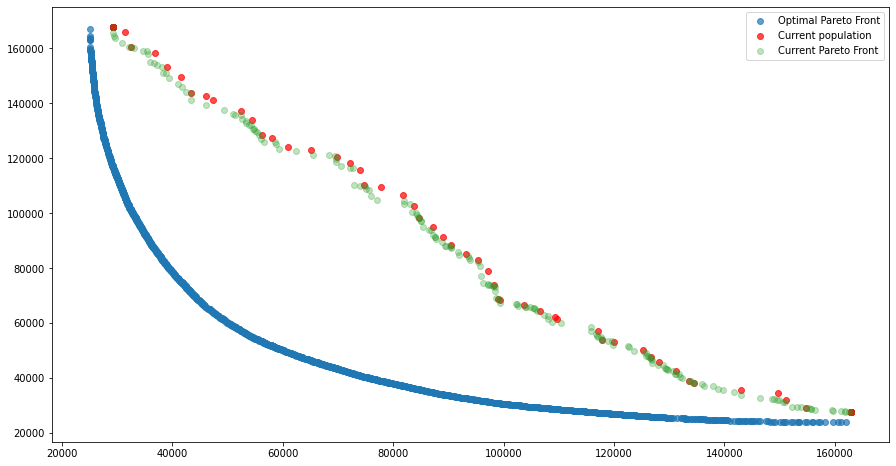

current population hypervolume: 0.63
hypervolume: 0.65
diveristy: 0.71
time: 1.73, Iteartions: 1.00 done


In [26]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 50
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.5

moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
              decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead.run(verbose=True)

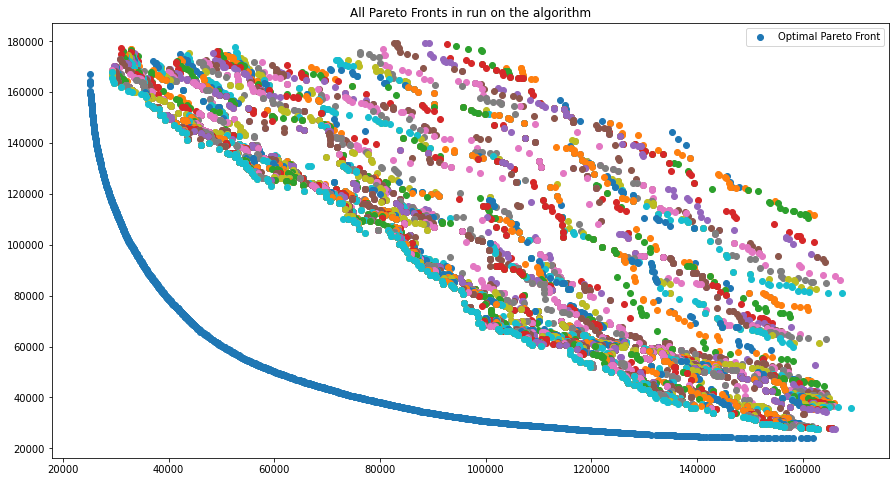

In [27]:
moead.plot_all()

In [28]:
print("Last population hypervolume:", hypervolume(moead.objective_values, objective_f.solutions))
print("Pareto Front hypervolume:", hypervolume(moead.external_population, objective_f.solutions))

Last population hypervolume: 0.6281008244745011
Pareto Front hypervolume: 0.6479249400731254


### Prawdopodobieństwo mutacji

In [37]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 50
subproblem_count = 70
num_nearest = 10
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.5

results_mutation_probs = {"mutation_prob": [], "hypervolume": []}
mutation_probs = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

for mutation_prob in tqdm(mutation_probs):
    moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
                  decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
    moead.run(verbose=False)
    results_mutation_probs["mutation_prob"].append(mutation_prob)
    results_mutation_probs["hypervolume"].append(hypervolume(moead.objective_values, objective_f.solutions))

  0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
pd.DataFrame(results_mutation_probs)

,mutation_prob,hypervolume
0,0.05,0.560602
1,0.10,0.566075
2,0.20,0.693870
3,0.30,0.707046
4,0.50,0.681714
5,0.70,0.652397
6,0.90,0.618347


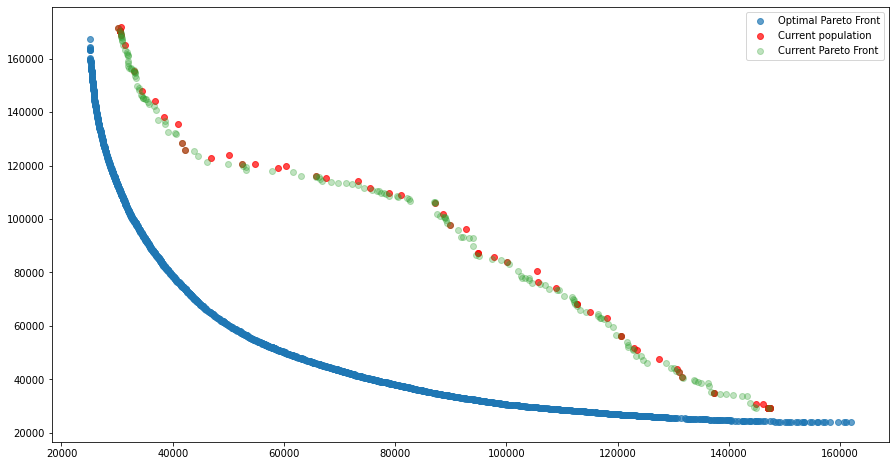

current population hypervolume: 0.64
hypervolume: 0.66
diveristy: 0.70
time: 1.67, Iteartions: 1.00 done


In [42]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 50
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
              decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead.run(verbose=True)

In [43]:
print("Last population hypervolume:", hypervolume(moead.objective_values, objective_f.solutions))
print("Pareto Front hypervolume:", hypervolume(moead.external_population, objective_f.solutions))

Last population hypervolume: 0.6440556956729085
Pareto Front hypervolume: 0.6584236334421308


### Liczba dzieci

In [49]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
subproblem_count = 70
num_nearest = 10
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

results_offspring_sizes = {"offspring_size": [], "hypervolume": []}
offspring_sizes = [2, 5, 10, 20, 50, 70, 140, 300]

for offspring_size in tqdm(offspring_sizes):
    moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
                  decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
    moead.run(verbose=False)
    results_offspring_sizes["offspring_size"].append(offspring_size)
    results_offspring_sizes["hypervolume"].append(hypervolume(moead.objective_values, objective_f.solutions))

  0%|          | 0/8 [00:00<?, ?it/s]

In [47]:
offspring_size

5

In [50]:
pd.DataFrame(results_offspring_sizes)

,offspring_size,hypervolume
0,2,0.196376
1,5,0.306766
2,10,0.457047
3,20,0.551335
4,50,0.706741
5,70,0.731570
6,140,0.739485
7,300,0.833677


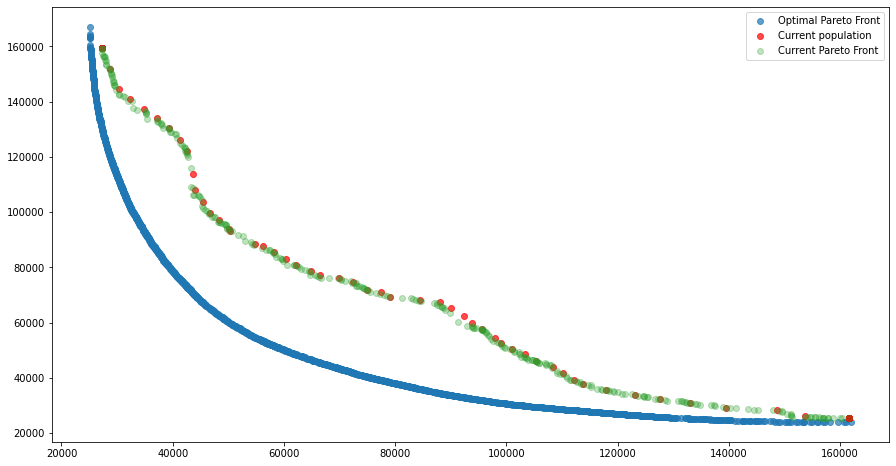

current population hypervolume: 0.81
hypervolume: 0.83
diveristy: 0.73
time: 5.34, Iteartions: 1.00 done


In [54]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 300
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
              decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead.run(verbose=True)

In [55]:
print("Last population hypervolume:", hypervolume(moead.objective_values, objective_f.solutions))
print("Pareto Front hypervolume:", hypervolume(moead.external_population, objective_f.solutions))

Last population hypervolume: 0.8133615660793765
Pareto Front hypervolume: 0.825114470805227


### Metody podmiany populacji

In [13]:
class MOEAD_all_children:
    def __init__(self, objective_f, iterations, offspring_size, num_nearest, weights,
                 decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob):
        self.objective_f = objective_f
        self.iterations = iterations
        self.offspring_size = offspring_size
        self.num_nearest = num_nearest
        self.weights = weights
        self.decompose_f = decompose_f
        self.crossover_f = crossover_f
        self.crossover_prob = crossover_prob
        self.mutation_f = mutation_f
        self.mutation_prob = mutation_prob
        self.reference_point = np.zeros(objective_f.num_objectives)
        self.nearest_indices = np.argsort(cdist(weights, weights), axis=1)[:, :num_nearest]
        self.pop_size = weights.shape[0]
        self.dimensions = objective_f.dimensions
        self.external_populations = []
        self.external_population = np.array([])
        self.populations_objective_values = []
        
    def run(self, verbose=True):
        self.population = generate_population(self.pop_size, self.dimensions)
        self.objective_values = self.objective_f(self.population)
        self.decomposed_values = self.decompose_f(self.objective_values, self.weights, self.reference_point)
        self.populations_objective_values.append(self.objective_values.copy())
    
        if verbose:
            print("initial diverisity:", self.get_diversity())
        
        for t in range(self.iterations):
            
            # saving for logs
            last_decomposed_values = self.decomposed_values.copy()
            t0 = time.time()
                
            # iterate through subproblems
            for i in range(self.pop_size):
                
                # generate children with i-th subproblem solution as base
                parent_indices = np.random.choice(self.nearest_indices[i], self.offspring_size, replace=True)
                children = np.empty((self.offspring_size, self.dimensions), dtype=np.int32)
                for j in range(0, self.offspring_size - 1, 2):
                    if np.random.random() < self.crossover_prob:
                        children[j], children[j + 1] = self.crossover_f(self.population[parent_indices[j]], self.population[parent_indices[j + 1]])
                    else:
                        children[j], children[j + 1] = self.population[parent_indices[j]], self.population[parent_indices[j + 1]]
                if np.mod(self.offspring_size, 2) == 1:
                    children[-1] = self.population[parent_indices[-1]]
                    
                # mutate children
                for j in range(self.offspring_size):
                    if np.random.random() < self.mutation_prob:
                        children[j] = self.mutation_f(children[j])
                        
                # evaluate children
                children_objective_values = objective_f(children)
                
                # replace current neighbors with better children
                for child, child_objective_value in zip(children, children_objective_values):
                    child_decomposed_values = self.decompose_f(child_objective_value.reshape(1, -1), self.weights[self.nearest_indices[i]], self.reference_point)
                    assert child_decomposed_values.shape == (self.num_nearest,)
                    better_mask = child_decomposed_values < self.decomposed_values[self.nearest_indices[i]]
                    better_ind = self.nearest_indices[i][better_mask]
                    self.population[better_ind] = child
                    self.objective_values[better_ind] = child_objective_value
                    self.decomposed_values[better_ind] = child_decomposed_values[better_mask]
                    self.sanity_check()
                
                # possibly add children to the new population
                for j in range(self.offspring_size):
                    self.update_external_population(children_objective_values[j])
                
            # logging
            self.external_populations.append(np.array(self.external_population))
            self.populations_objective_values.append(self.objective_values.copy())
            
            if verbose and (t + 1) % 1 == 0:
                self.plot()
                print("current population hypervolume: %.2f" % (self.get_current_population_hypervolume()))
                print("hypervolume: %.2f" % (self.get_hypervolume()))
                print("diveristy: %.2f" % (self.get_diversity()))
                print("time: %.2f, Iteartions: %.2f done" % (time.time() - t0, (t + 1) / self.iterations))

    def get_diversity(self):
        return np.unique(self.population, axis=0).shape[0] / self.pop_size
    
    def get_current_population_hypervolume(self):
        return hypervolume(self.objective_values, self.objective_f.solutions)
    
    def get_hypervolume(self):
        return hypervolume(np.array(self.external_population), self.objective_f.solutions)
        
    def sanity_check(self):
        objective_values = self.objective_f(self.population)
        assert np.all(objective_values == self.objective_values)
        decomposed_values = self.decompose_f(objective_values, self.weights, self.reference_point)
        assert np.all(decomposed_values == self.decomposed_values)

    def update_external_population(self, child):
        if len(self.external_population) == 0:
            self.external_population = child.reshape(1, -1)
        who_dominates = self.dominates(child, self.external_population)
        if not np.any(who_dominates):
            is_dominated = self.dominates(self.external_population, child)
            if not np.any(is_dominated):
                self.external_population = np.vstack((self.external_population, child))
        else:
            self.external_population = np.vstack((self.external_population[~who_dominates], child))
               
    def dominates(self, a1, a2):
        return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

    def plot(self):
        assert self.objective_f.num_objectives == 2
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.scatter(objective_f.solutions[:, 0], objective_f.solutions[:, 1], c="tab:blue", alpha=0.7, label="Optimal Pareto Front")
        plt.scatter(self.objective_values[:, 0], self.objective_values[:, 1], c="red", alpha=0.7, label="Current population")
        pareto_front = self.get_pareto_front()
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="tab:green", label="Current Pareto Front", alpha=0.3)
        plt.legend()
        plt.show()
        
    def get_pareto_front(self):
        return self.external_populations[-1]

    def plot_all_fronts(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for external_population in self.external_populations[::step]:
            plt.scatter(external_population[:, 0], external_population[:, 1])
        plt.title("All Pareto Fronts in run of the algorithm")
        plt.legend()
        plt.show()
    
    def plot_all_pops(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for population_objective_values in self.populations_objective_values[::step]:
            plt.scatter(population_objective_values[:, 0], population_objective_values[:, 1])
        plt.title("All populations in run of the algorithm")
        plt.legend()
        plt.show()
    
    
class MOEAD_only_one:
    def __init__(self, objective_f, iterations, offspring_size, num_nearest, weights,
                 decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob):
        self.objective_f = objective_f
        self.iterations = iterations
        self.offspring_size = offspring_size
        self.num_nearest = num_nearest
        self.weights = weights
        self.decompose_f = decompose_f
        self.crossover_f = crossover_f
        self.crossover_prob = crossover_prob
        self.mutation_f = mutation_f
        self.mutation_prob = mutation_prob
        self.reference_point = np.zeros(objective_f.num_objectives)
        self.nearest_indices = np.argsort(cdist(weights, weights), axis=1)[:, :num_nearest]
        self.pop_size = weights.shape[0]
        self.dimensions = objective_f.dimensions
        self.external_populations = []
        self.external_population = np.array([])
        self.populations_objective_values = []
        
    def run(self, verbose=True):
        self.population = generate_population(self.pop_size, self.dimensions)
        self.objective_values = self.objective_f(self.population)
        self.decomposed_values = self.decompose_f(self.objective_values, self.weights, self.reference_point)
        self.populations_objective_values.append(self.objective_values.copy())
            
        if verbose:
            print("initial diverisity:", self.get_diversity())
        
        for t in range(self.iterations):
            # saving for logs
            last_decomposed_values = self.decomposed_values.copy()
            t0 = time.time()
                
            # iterate through subproblems
            for i in range(self.pop_size):
                
                # generate children with i-th subproblem solution as base
                parent_indices = np.random.choice(self.nearest_indices[i], self.offspring_size, replace=True)
                children = np.empty((self.offspring_size, self.dimensions), dtype=np.int32)
                for j in range(0, self.offspring_size - 1, 2):
                    if np.random.random() < self.crossover_prob:
                        children[j], children[j + 1] = self.crossover_f(self.population[parent_indices[j]], self.population[parent_indices[j + 1]])
                    else:
                        children[j], children[j + 1] = self.population[parent_indices[j]], self.population[parent_indices[j + 1]]
                if np.mod(self.offspring_size, 2) == 1:
                    children[-1] = self.population[parent_indices[-1]]
                    
                # mutate children
                for j in range(self.offspring_size):
                    if np.random.random() < self.mutation_prob:
                        children[j] = self.mutation_f(children[j])
                        
                # evaluate children
                children_objective_values = objective_f(children)
                
                # only replace this subproblem individual with better children
                children_decomposed_values = self.decompose_f(children_objective_values, self.weights[i], self.reference_point)
                best_child = np.argmin(children_decomposed_values)
                if children_decomposed_values[best_child] < self.decomposed_values[i]:
                    self.population[i] = children[best_child]
                    self.objective_values[i] = children_objective_values[best_child]
                    self.decomposed_values[i] = children_decomposed_values[best_child]
                self.sanity_check()
                
                # possibly add children to the new population
                for j in range(self.offspring_size):
                    self.update_external_population(children_objective_values[j])
                
            # logging
            self.external_populations.append(np.array(self.external_population))
            self.populations_objective_values.append(self.objective_values.copy())
            
            if verbose and (t + 1) % 1 == 0:
                self.plot()
                print("current population hypervolume: %.2f" % (self.get_current_population_hypervolume()))
                print("hypervolume: %.2f" % (self.get_hypervolume()))
                print("diveristy: %.2f" % (self.get_diversity()))
                print("time: %.2f, Iteartions: %.2f done" % (time.time() - t0, (t + 1) / self.iterations))

    def get_diversity(self):
        return np.unique(self.population, axis=0).shape[0] / self.pop_size
    
    def get_current_population_hypervolume(self):
        return hypervolume(self.objective_values, self.objective_f.solutions)
    
    def get_hypervolume(self):
        return hypervolume(np.array(self.external_population), self.objective_f.solutions)
        
    def sanity_check(self):
        objective_values = self.objective_f(self.population)
        assert np.all(objective_values == self.objective_values)
        decomposed_values = self.decompose_f(objective_values, self.weights, self.reference_point)
        assert np.all(decomposed_values == self.decomposed_values)

    def update_external_population(self, child):
        if len(self.external_population) == 0:
            self.external_population = child.reshape(1, -1)
        who_dominates = self.dominates(child, self.external_population)
        if not np.any(who_dominates):
            is_dominated = self.dominates(self.external_population, child)
            if not np.any(is_dominated):
                self.external_population = np.vstack((self.external_population, child))
        else:
            self.external_population = np.vstack((self.external_population[~who_dominates], child))
               
    def dominates(self, a1, a2):
        return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

    def plot(self):
        assert self.objective_f.num_objectives == 2
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.scatter(objective_f.solutions[:, 0], objective_f.solutions[:, 1], c="tab:blue", alpha=0.7, label="Optimal Pareto Front")
        plt.scatter(self.objective_values[:, 0], self.objective_values[:, 1], c="red", alpha=0.7, label="Current population")
        pareto_front = self.get_pareto_front()
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="tab:green", label="Current Pareto Front", alpha=0.3)
        plt.legend()
        plt.show()
        
    def get_pareto_front(self):
        return self.external_populations[-1]

    def plot_all_fronts(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for external_population in self.external_populations[::step]:
            plt.scatter(external_population[:, 0], external_population[:, 1])
        plt.title("All Pareto Fronts in run on the algorithm")
        plt.legend()
        plt.show()
        
    def plot_all_pops(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for population_objective_values in self.populations_objective_values[::step]:
            plt.scatter(population_objective_values[:, 0], population_objective_values[:, 1])
        plt.title("All populations in run of the algorithm")
        plt.legend()
        plt.show()

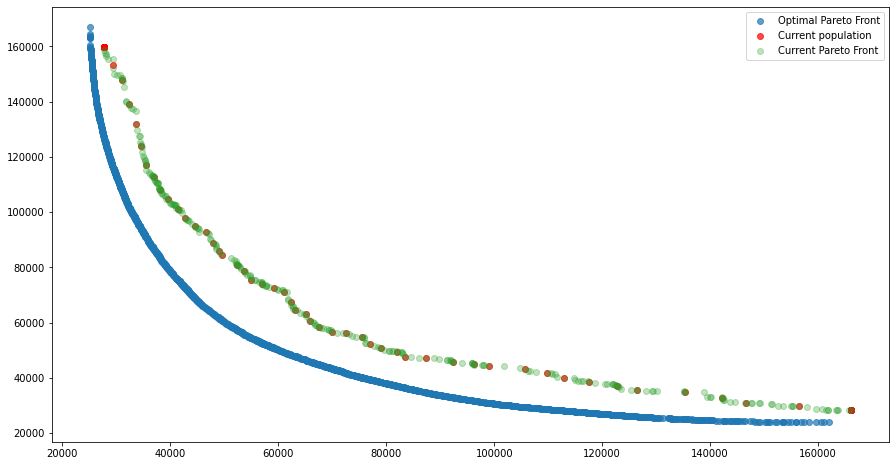

current population hypervolume: 0.87
hypervolume: 0.88
diveristy: 0.71
time: 69.65, Iteartions: 1.00 done


In [59]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 140
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead_all_children = MOEAD_all_children(objective_f, iterations, offspring_size, num_nearest, weights,
                                        decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
t0 = time.time()
moead_all_children.run(verbose=True)
all_children_time = time.time() - t0

In [60]:
print("All children MOEAD:")
print("\ttime in total:", all_children_time)
print("\tlast population hypervolume:", moead_all_children.get_current_population_hypervolume())
print("\tpareto front hypervolume:", moead_all_children.get_hypervolume())

All children MOEAD:
	time in total: 6884.031794309616
	last population hypervolume: 0.8716714725403333
	pareto front hypervolume: 0.8784632661728059


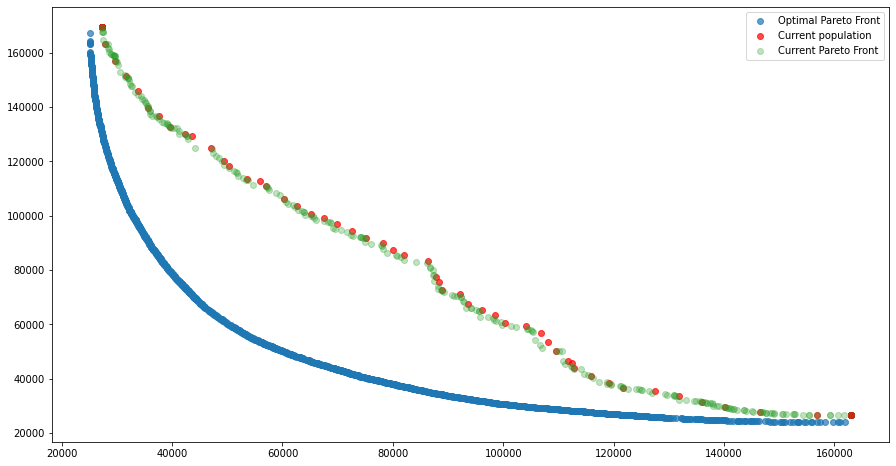

current population hypervolume: 0.74
hypervolume: 0.75
diveristy: 0.74
time: 2.50, Iteartions: 1.00 done


In [61]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 140
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead_only_one = MOEAD_only_one(objective_f, iterations, offspring_size, num_nearest, weights,
                                decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
t0 = time.time()
moead_only_one.run(verbose=True)
only_one_time = time.time() - t0

In [62]:
print("Only one MOEAD:")
print("\ttime in total:", only_one_time)
print("\tlast population hypervolume:", moead_only_one.get_current_population_hypervolume())
print("\tpareto front hypervolume:", moead_only_one.get_hypervolume())

Only one MOEAD:
	time in total: 242.16564273834229
	last population hypervolume: 0.7394703869073067
	pareto front hypervolume: 0.7535151425139025


### Porównanie metody Czebyszewa z sumą ważoną

In [63]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 70
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

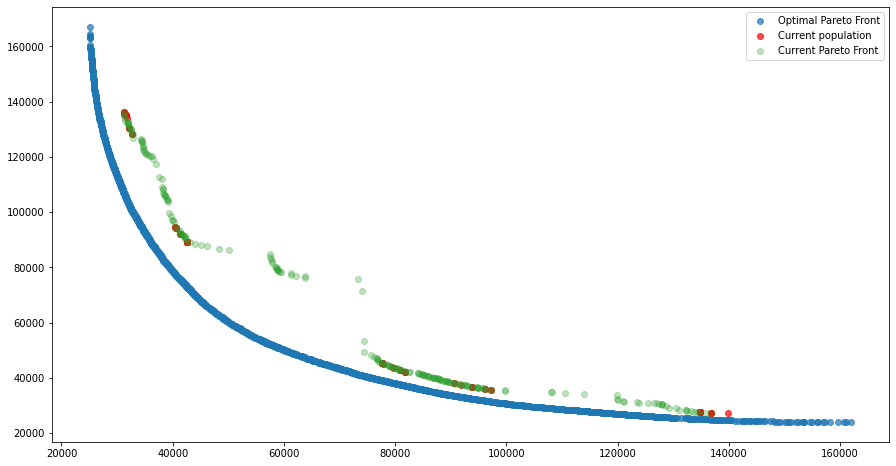

current population hypervolume: 0.86
hypervolume: 0.89
diveristy: 0.34
time: 1.76, Iteartions: 1.00 done


In [64]:
moead_weighted_sum = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
                           weighted_sum, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead_weighted_sum.run(verbose=True)

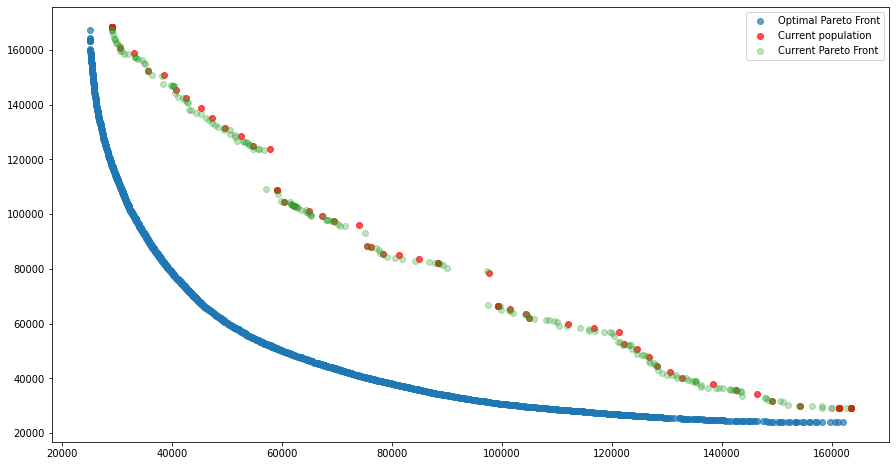

current population hypervolume: 0.68
hypervolume: 0.69
diveristy: 0.67
time: 2.27, Iteartions: 1.00 done


In [65]:
moead_tchebycheff = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
                          tchebycheff, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead_tchebycheff.run(verbose=True)

## Optymalizacja

### Zmienione metody decompozycji

In [17]:
def weighted_sum_modified(objective_values, weights, *args):
    return objective_values @ weights.T

def tchebycheff_modified(objective_values, weights, reference_point, *args):
    return np.max(weights * (objective_values - reference_point).reshape(-1, 1, weights.shape[1]), axis=2)

In [26]:
def original_method(decompose_f, objective_values, weights, *args):
    decomposed_values = []
    for objective_value in objective_values:
        decomposed_values.append(decompose_f(objective_value.reshape(1, -1), weights, *args))
    return np.array(decomposed_values)

def modified_method(decompose_f, objective_values, weights, *args):
    return decompose_f(objective_values, weights, *args)

In [33]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
pop_size = 10
population = generate_population(pop_size, objective_f.dimensions)
objective_values = objective_f(population)
subproblem_count = 5
weights = generate_weights(subproblem_count, objective_f.num_objectives)
reference_point = np.zeros(objective_f.num_objectives)

In [40]:
assert np.all(original_method(weighted_sum, objective_values, weights) ==
              modified_method(weighted_sum_modified, objective_values, weights))

In [41]:
assert np.all(original_method(tchebycheff, objective_values, weights, reference_point) ==
              modified_method(tchebycheff_modified, objective_values, weights, reference_point))

In [43]:
%timeit original_method(weighted_sum, objective_values, weights)
%timeit modified_method(weighted_sum_modified, objective_values, weights)

82.1 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.34 µs ± 89.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [45]:
%timeit original_method(tchebycheff, objective_values, weights, reference_point)
%timeit modified_method(tchebycheff_modified, objective_values, weights, reference_point)

95.3 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
9.13 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Test wydajności

In [85]:
class MOEAD_all_children_optimized:
    def __init__(self, objective_f, iterations, offspring_size, num_nearest, weights,
                 decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob):
        self.objective_f = objective_f
        self.iterations = iterations
        self.offspring_size = offspring_size
        self.num_nearest = num_nearest
        self.weights = weights
        self.decompose_f = decompose_f
        self.crossover_f = crossover_f
        self.crossover_prob = crossover_prob
        self.mutation_f = mutation_f
        self.mutation_prob = mutation_prob
        self.reference_point = np.zeros(objective_f.num_objectives)
        self.nearest_indices = np.argsort(cdist(weights, weights), axis=1)[:, :num_nearest]
        self.pop_size = weights.shape[0]
        self.dimensions = objective_f.dimensions
        self.external_populations = []
        self.external_population = np.array([])
        
    def run(self, verbose=True):
        self.population = generate_population(self.pop_size, self.dimensions)
        self.objective_values = self.objective_f(self.population)
#         self.decomposed_values = self.decompose_f(self.objective_values, self.weights, self.reference_point)
        self.decomposed_values = np.empty(self.pop_size)
        for i in range(self.pop_size):
            self.decomposed_values[i] = self.decompose_f(self.objective_values[i:i+1], self.weights[i:i+1], self.reference_point)[0, 0]
    
        if verbose:
            print("initial diverisity:", self.get_diversity())
        
        for t in range(self.iterations):
            
            # saving for logs
            last_decomposed_values = self.decomposed_values.copy()
            t0 = time.time()
                
            # iterate through subproblems
            for i in range(self.pop_size):
                
                # generate children with i-th subproblem solution as base
                parent_indices = np.random.choice(self.nearest_indices[i], self.offspring_size, replace=True)
                children = np.empty((self.offspring_size, self.dimensions), dtype=np.int32)
                for j in range(0, self.offspring_size - 1, 2):
                    if np.random.random() < self.crossover_prob:
                        children[j], children[j + 1] = self.crossover_f(self.population[parent_indices[j]], self.population[parent_indices[j + 1]])
                    else:
                        children[j], children[j + 1] = self.population[parent_indices[j]], self.population[parent_indices[j + 1]]
                if np.mod(self.offspring_size, 2) == 1:
                    children[-1] = self.population[parent_indices[-1]]
                    
                # mutate children
                for j in range(self.offspring_size):
                    if np.random.random() < self.mutation_prob:
                        children[j] = self.mutation_f(children[j])
                        
                # evaluate children
                children_objective_values = objective_f(children)
                
                # replace current neighbors with better children
#                 print("children_objective_values", children_objective_values)
                nearest_weights = self.weights[self.nearest_indices[i]]
#                 print("nearest_weights", nearest_weights)
                children_decomposed_values = self.decompose_f(children_objective_values, nearest_weights, self.reference_point)
#                 print("children_decomposed_values", children_decomposed_values)
                best_children_indices = np.argmin(children_decomposed_values, axis=0)
#                 print("best_children_indices", best_children_indices)
                best_children_decomposed_values = children_decomposed_values[best_children_indices, np.arange(self.num_nearest)]
#                 assert best_children_decomposed_values.shape == (self.num_nearest,)
#                 print("best_children_decomposed_values", best_children_decomposed_values)
                better_mask = best_children_decomposed_values < self.decomposed_values[self.nearest_indices[i]]
#                 print("better_mask", better_mask)
                better_indices = self.nearest_indices[i][better_mask]
#                 print("better_indices", better_indices)
                self.population[better_indices] = children[best_children_indices][better_mask]
                self.objective_values[better_indices] = children_objective_values[best_children_indices][better_mask]
                self.decomposed_values[better_indices] = best_children_decomposed_values[better_mask]
                self.sanity_check()
                
                
#                 for child, child_objective_value in zip(children, children_objective_values):
#                     child_decomposed_values = self.decompose_f(child_objective_value.reshape(1, -1), self.weights[self.nearest_indices[i]], self.reference_point)
#                     assert child_decomposed_values.shape == (self.num_nearest,)
#                     better_mask = child_decomposed_values < self.decomposed_values[self.nearest_indices[i]]
#                     better_ind = self.nearest_indices[i][better_mask]
#                     self.population[better_ind] = child
#                     self.objective_values[better_ind] = child_objective_value
#                     self.decomposed_values[better_ind] = child_decomposed_values[better_mask]
#                     self.sanity_check()
                
                # possibly add children to the new population
                for j in range(self.offspring_size):
                    self.update_external_population(children_objective_values[j])
                
            # logging
            self.external_populations.append(np.array(self.external_population))
            
            if verbose and (t + 1) % 1 == 0:
                self.plot()
                print("current population hypervolume: %.2f" % (self.get_current_population_hypervolume()))
                print("hypervolume: %.2f" % (self.get_hypervolume()))
                print("diveristy: %.2f" % (self.get_diversity()))
                print("time: %.2f, Iteartions: %.2f done" % (time.time() - t0, (t + 1) / self.iterations))

    def get_diversity(self):
        return np.unique(self.population, axis=0).shape[0] / self.pop_size
    
    def get_current_population_hypervolume(self):
        return hypervolume(self.objective_values, self.objective_f.solutions)
    
    def get_hypervolume(self):
        return hypervolume(np.array(self.external_population), self.objective_f.solutions)
        
    def sanity_check(self):
        objective_values = self.objective_f(self.population)
        assert np.all(objective_values == self.objective_values)
#         decomposed_values = self.decompose_f(self.objective_values, self.weights, self.reference_point)
        for i in range(self.pop_size):
            assert self.decomposed_values[i] == self.decompose_f(self.objective_values[i:i+1], self.weights[i:i+1], self.reference_point)[0, 0]
#         assert np.all(decomposed_values == self.decomposed_values)

    def update_external_population(self, child):
        if len(self.external_population) == 0:
            self.external_population = child.reshape(1, -1)
        who_dominates = self.dominates(child, self.external_population)
        if not np.any(who_dominates):
            is_dominated = self.dominates(self.external_population, child)
            if not np.any(is_dominated):
                self.external_population = np.vstack((self.external_population, child))
        else:
            self.external_population = np.vstack((self.external_population[~who_dominates], child))
               
    def dominates(self, a1, a2):
        return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

    def plot(self):
        assert self.objective_f.num_objectives == 2
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.scatter(objective_f.solutions[:, 0], objective_f.solutions[:, 1], c="tab:blue", alpha=0.7, label="Optimal Pareto Front")
        plt.scatter(self.objective_values[:, 0], self.objective_values[:, 1], c="red", alpha=0.7, label="Current population")
        pareto_front = self.get_pareto_front()
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="tab:green", label="Current Pareto Front", alpha=0.3)
        plt.legend()
        plt.show()
        
    def plot_all(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for external_population in self.external_populations[::step]:
            plt.scatter(external_population[:, 0], external_population[:, 1])
        plt.title("All Pareto Fronts in run on the algorithm")
        plt.legend()
        plt.show()
        
    def get_pareto_front(self):
        return self.external_populations[-1]

Oryginalna metoda

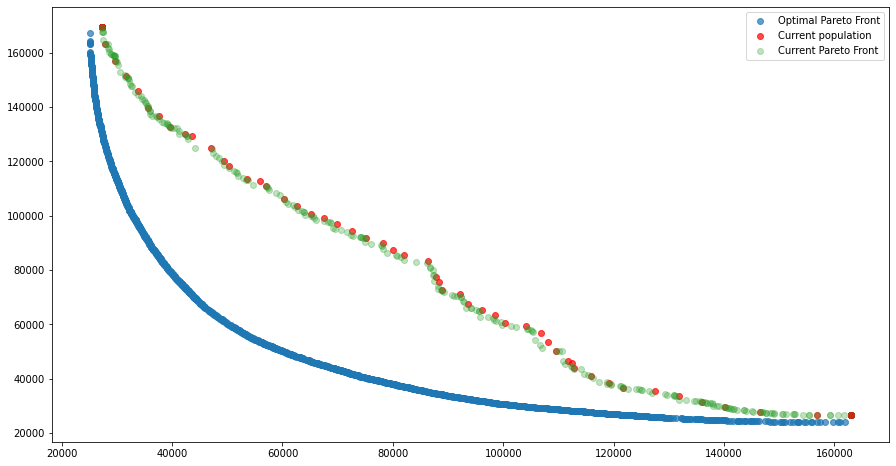

current population hypervolume: 0.74
hypervolume: 0.75
diveristy: 0.74
time: 2.50, Iteartions: 1.00 done


In [61]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 140
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead_only_one = MOEAD_only_one(objective_f, iterations, offspring_size, num_nearest, weights,
                                decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
t0 = time.time()
moead_only_one.run(verbose=True)
only_one_time = time.time() - t0

In [60]:
print("All children MOEAD:")
print("\ttime in total:", all_children_time)
print("\tlast population hypervolume:", moead_all_children.get_current_population_hypervolume())
print("\tpareto front hypervolume:", moead_all_children.get_hypervolume())

All children MOEAD:
	time in total: 6884.031794309616
	last population hypervolume: 0.8716714725403333
	pareto front hypervolume: 0.8784632661728059


Zoptymalizowana metoda

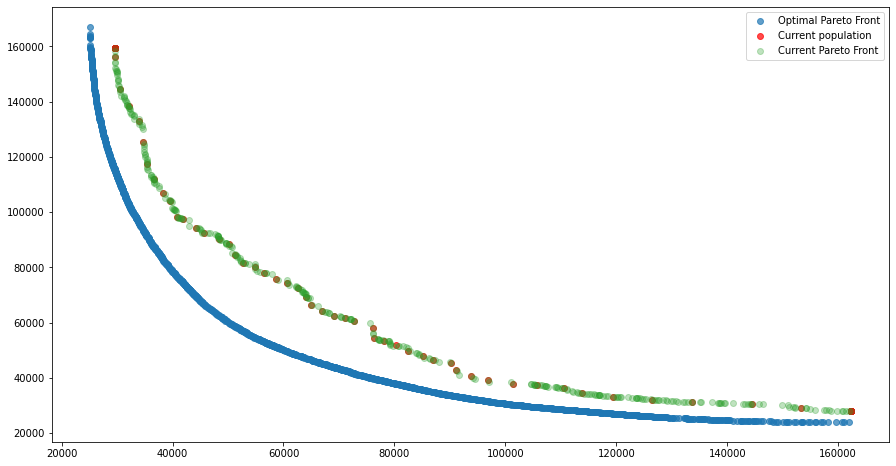

current population hypervolume: 0.88
hypervolume: 0.88
diveristy: 0.71
time: 2.87, Iteartions: 1.00 done


In [86]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 100
offspring_size = 140
num_nearest = 10
subproblem_count = 70
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff_modified
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead_all_children_optimized = MOEAD_all_children_optimized(objective_f, iterations, offspring_size, num_nearest, weights,
                                                  decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
t0 = time.time()
moead_all_children_optimized.run(verbose=True)
all_children_optimized_time = time.time() - t0

In [87]:
print("All children optimized MOEAD:")
print("\ttime in total:", all_children_optimized_time)
print("\tlast population hypervolume:", moead_all_children_optimized.get_current_population_hypervolume())
print("\tpareto front hypervolume:", moead_all_children_optimized.get_hypervolume())

All children optimized MOEAD:
	time in total: 293.8767123222351
	last population hypervolume: 0.8774628146164295
	pareto front hypervolume: 0.883344735235383


## Algorytm - zoptymalizowany

In [7]:
class MOEAD:
    def __init__(self, objective_f, iterations, offspring_size, num_nearest, weights,
                 decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob):
        self.objective_f = objective_f
        self.iterations = iterations
        self.offspring_size = offspring_size
        self.num_nearest = num_nearest
        self.weights = weights
        self.decompose_f = decompose_f
        self.crossover_f = crossover_f
        self.crossover_prob = crossover_prob
        self.mutation_f = mutation_f
        self.mutation_prob = mutation_prob
        self.reference_point = np.zeros(objective_f.num_objectives)
        self.nearest_indices = np.argsort(cdist(weights, weights), axis=1)[:, :num_nearest]
        self.pop_size = weights.shape[0]
        self.dimensions = objective_f.dimensions
        self.external_populations = []
        self.external_population = np.array([])
        
    def run(self, verbose=True):
        self.population = generate_population(self.pop_size, self.dimensions)
        self.objective_values = self.objective_f(self.population)
        self.decomposed_values = np.empty(self.pop_size)
        for i in range(self.pop_size):
            self.decomposed_values[i] = self.decompose_f(self.objective_values[i:i+1], self.weights[i:i+1], self.reference_point)[0, 0]
    
        if verbose:
            print("initial diverisity:", self.get_diversity())
        
        for t in range(self.iterations):
            
            # saving for logs
            last_decomposed_values = self.decomposed_values.copy()
            t0 = time.time()
                
            # iterate through subproblems
            for i in range(self.pop_size):
                
                # generate children with i-th subproblem solution as base
                parent_indices = np.random.choice(self.nearest_indices[i], self.offspring_size, replace=True)
                children = np.empty((self.offspring_size, self.dimensions), dtype=np.int32)
                for j in range(0, self.offspring_size - 1, 2):
                    if np.random.random() < self.crossover_prob:
                        children[j], children[j + 1] = self.crossover_f(self.population[parent_indices[j]], self.population[parent_indices[j + 1]])
                    else:
                        children[j], children[j + 1] = self.population[parent_indices[j]], self.population[parent_indices[j + 1]]
                if np.mod(self.offspring_size, 2) == 1:
                    children[-1] = self.population[parent_indices[-1]]
                    
                # mutate children
                for j in range(self.offspring_size):
                    if np.random.random() < self.mutation_prob:
                        children[j] = self.mutation_f(children[j])
                        
                # evaluate children
                children_objective_values = objective_f(children)
                
                # replace current neighbors with better children
                nearest_weights = self.weights[self.nearest_indices[i]]
                children_decomposed_values = self.decompose_f(children_objective_values, nearest_weights, self.reference_point)
                best_children_indices = np.argmin(children_decomposed_values, axis=0)
                best_children_decomposed_values = children_decomposed_values[best_children_indices, np.arange(self.num_nearest)]
                better_mask = best_children_decomposed_values < self.decomposed_values[self.nearest_indices[i]]
                better_indices = self.nearest_indices[i][better_mask]
                self.population[better_indices] = children[best_children_indices][better_mask]
                self.objective_values[better_indices] = children_objective_values[best_children_indices][better_mask]
                self.decomposed_values[better_indices] = best_children_decomposed_values[better_mask]
                self.sanity_check()
                
                # possibly add children to the new population
                for j in range(self.offspring_size):
                    self.update_external_population(children_objective_values[j])
                
            # logging
            self.external_populations.append(np.array(self.external_population))
            
            if verbose and (t + 1) % 1 == 0:
                self.plot()
                print("current population hypervolume: %.2f" % (self.get_current_population_hypervolume()))
                print("hypervolume: %.2f" % (self.get_hypervolume()))
                print("diveristy: %.2f" % (self.get_diversity()))
                print("time: %.2f, Iteartions: %.2f done" % (time.time() - t0, (t + 1) / self.iterations))

    def get_diversity(self):
        return np.unique(self.population, axis=0).shape[0] / self.pop_size
    
    def get_current_population_hypervolume(self):
        return hypervolume(self.objective_values, self.objective_f.solutions)
    
    def get_hypervolume(self):
        return hypervolume(np.array(self.external_population), self.objective_f.solutions)
        
    def sanity_check(self):
        objective_values = self.objective_f(self.population)
        assert np.all(objective_values == self.objective_values)
        for i in range(self.pop_size):
            assert self.decomposed_values[i] == self.decompose_f(self.objective_values[i:i+1], self.weights[i:i+1], self.reference_point)[0, 0]

    def update_external_population(self, child):
        if len(self.external_population) == 0:
            self.external_population = child.reshape(1, -1)
        who_dominates = self.dominates(child, self.external_population)
        if not np.any(who_dominates):
            is_dominated = self.dominates(self.external_population, child)
            if not np.any(is_dominated):
                self.external_population = np.vstack((self.external_population, child))
        else:
            self.external_population = np.vstack((self.external_population[~who_dominates], child))
               
    def dominates(self, a1, a2):
        return np.all(a1 <= a2, axis=1) & np.any(a1 <= a2, axis=1)

    def plot(self):
        assert self.objective_f.num_objectives == 2
        clear_output(wait=True)
        plt.figure(figsize=(12, 12))
        plt.scatter(objective_f.solutions[:, 0], objective_f.solutions[:, 1], c="tab:blue", alpha=0.7, label="Optimal Pareto Front")
        plt.scatter(self.objective_values[:, 0], self.objective_values[:, 1], c="red", alpha=0.7, label="Current population")
        pareto_front = self.get_pareto_front()
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="tab:green", label="Current Pareto Front", alpha=0.3)
        plt.legend()
        plt.show()
        
    def plot_all(self, step=1):
        assert self.objective_f.num_objectives == 2
        plt.figure(figsize=(12, 12))
        plt.scatter(self.objective_f.solutions[:, 0], self.objective_f.solutions[:, 1], c="tab:blue", label="Optimal Pareto Front")
        for external_population in self.external_populations[::step]:
            plt.scatter(external_population[:, 0], external_population[:, 1])
        plt.title("All Pareto Fronts in run on the algorithm")
        plt.legend()
        plt.show()
        
    def get_pareto_front(self):
        return self.external_populations[-1]

## Metody dekompozycji - zoptymalizowane

In [8]:
def weighted_sum(objective_values, weights, *args):
    return objective_values @ weights.T

def tchebycheff(objective_values, weights, reference_point, *args):
    return np.max(weights * (objective_values - reference_point).reshape(-1, 1, weights.shape[1]), axis=2)

## Wyniki

### EuclidAB100

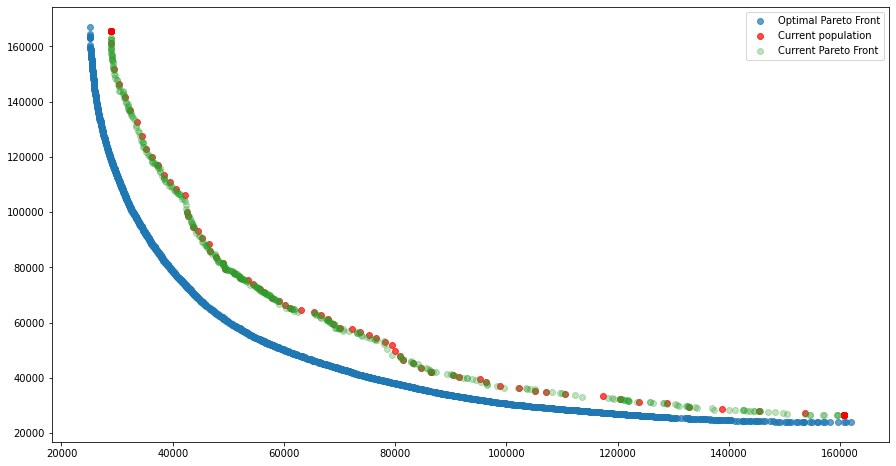

current population hypervolume: 0.90
hypervolume: 0.90
diveristy: 0.71
time: 2.57, Iteartions: 1.00 done


In [258]:
objective_f = get_tsp_objective_function("euclidA100", "euclidB100", "best.euclidAB100")
iterations = 1000
offspring_size = 50
subproblem_count = 100
num_nearest = min(10, subproblem_count)
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
              decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead.run()

### MixedGG100

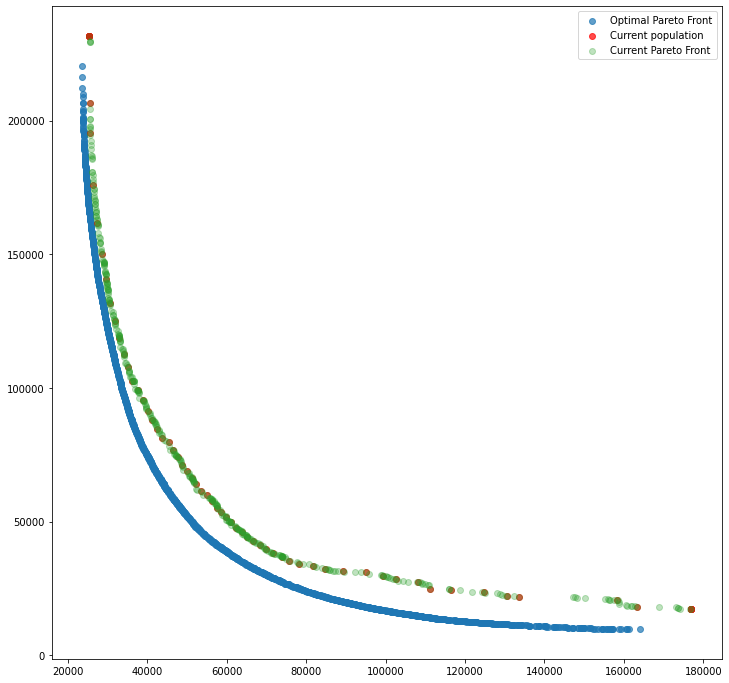

current population hypervolume: 0.93
hypervolume: 0.94
diveristy: 0.83
time: 3.10, Iteartions: 1.00 done


In [102]:
objective_f = get_tsp_objective_function("euclidG100", "randomG100", "best.mixedGG100")
iterations = 1000
offspring_size = 140
subproblem_count = 70
num_nearest = 10
weights = generate_weights(subproblem_count, objective_f.num_objectives)
decompose_f = tchebycheff
crossover_f = PMX
crossover_prob = 0.95
mutation_f = reverse_sequence_mutation
mutation_prob = 0.3

moead = MOEAD(objective_f, iterations, offspring_size, num_nearest, weights,
              decompose_f, crossover_f, crossover_prob, mutation_f, mutation_prob)
moead.run()